# **Введение**

### Постановка задачи
Оценка точного количества людей в комнате с помощью нескольких неинтрузивных датчиков окружающей среды, таких как температура, свет, звук, CO2 и PIR.

### Условия получения данных
Экспериментальный стенд для оценки занятости был развернут в помещении размером 6х4,6 м. В этой установке было 7 сенсорных узлов и один приемник, расположенный в центре звездообразной конфигурации, при этом сенсорные узлы отправляли данные приемнику каждые 30 секунд. Во время сбора набора данных не использовались системы HVAC (отопление, вентиляция и кондиционирование).

В этом эксперименте использовались пять различных типов неинтрузивных датчиков: температуры, света, звука, CO2 и цифрового пассивного инфракрасного излучения (PIR). Сенсорные узлы S1-S4 состояли из датчиков температуры, света и звука, S5 имел датчик CO2, а S6 и S7 имели по одному PIR-датчику, которые были развернуты на выступах потолка под углом, который максимизировал поле зрения датчика для обнаружения движения.

### Описание данных
Данные собирались в течение 4 дней контролируемым образом при наполняемости помещения от 0 до 3 человек. Фактические данные о количестве людей в комнате были отмечены вручную.

Информация о признаках:

Категориальные переменные:
* Дата: ГГГГ/ММ/ДД
* Время: ЧЧ:ММ:СС
* Room_Occupancy_Count: целевая переменная (4 значения - количество людей, от 0 до 3 )

Числовые переменные:
* Температура: в градусах Цельсия.
* Свет: в люксах (люкс — это мера того, сколько света падает на определенную поверхность).
* Звук: в вольтах (выход усилителя АЦП).
* CO2: в частях на миллион.
* Разница CO2: разница значений CO2, измеренных в скользящем окне, в частях на миллион.
* PIR: двоичное значение, передающее обнаружение движения (0 - нет, 1 - есть).

### Цели работы
Цели, которые должны быть достигнуты по результатам этой работы:
1. Анализ данных, взаимосвязь признаков, их влияние на целевую переменную. 
2. Построение моделей МО для предсказания присутствия и количества присутствующих людей в помещении. Выбор модели по точности предсказания (использование всех признаков). Дополнительно постороение baseline модели.
3. Отбор признаков. Методы снижения размерности (проекция и перебор).
4. Проверка моделей МО с использованием уменьшенного количества признаков (полученные варианты наборов признаков из отбора признаков). Дополнительно проверка baseline.
5. Сравнение точности моделей и разных наборов признаков.
6. Продакшен. Загрузка модели в файл, подготовка сервиса Flask.

### Выбранные метрики
В качестве метрик, исходя из того, что задача - задача классификации, будем использовать стандартные метрики:
- accuracy,
- precision (weighted),
- recall (weighted),
- f1 (weighted),
- f1 для каждого класса отдельно,
- сумма ошибочных значений для всех классов (т.е. сумма всех ошибок модели на конкретном предсказании),
- процентная доля суммы ошибочных значений для всех классов от объема тестовой выборки.

Из значений этих метрик для всех моделей составим общую таблицу.

Кроме того, для каждой модели будем выводить текстовый отчет результатов классификации classification_report (набор указанных метрик по классам и суммарно - взвешенно).

### Дополнительно
Договоримся обозначать классы как: 0, 1, 2 и 3, соответственно количеству людей в помещении.

Договоримся уменьшенным количеством признаков считать 5 (по числу групп однотипных признаков: температура, освещенность, звук, СО2 и движение). А минимальное количество необходимо определить с помощью методов снижения размерности.

# **Импорт библиотек**

In [1]:
import pandas as pd
import numpy as np

import time
import pickle

from scipy.stats import normaltest

import umap

from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo, FactorAnalyzer

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import lightgbm as lgb

import optuna
from optuna.terminator.callback import TerminatorCallback
from optuna.terminator.erroreval import report_cross_validation_scores

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [138]:
# время начала записи
start = time.time()


# **Проверка и подготовка данных**

## Загрузка датасета

In [2]:
data = pd.read_csv('data/Occupancy_Estimation.csv')

print(f'Number of records and attributes: {data.shape}')

data.head(3)


Number of records and attributes: (10129, 19)


,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1


## Исключение неинформативных признаков

Признаки даты и времени необходимо исключить, т.к. мы рассматриваем зависимость величин определенных физических параметров (температура, освещенность, звук, насыщенность углекислым газом и фиксация движения) от присутствия\отсутствия и количества присутствующих в помещении людей. Зависимость присутствия людей от дня недели и часа суток нас не интересует. Это, по сути, совсем другая задача (временной ряд).

In [3]:
data = data.drop(['Date', 'Time'], axis=1)

# обозначим список признаков и целевую переменную
features_list = data.columns.to_list()[:-1]
target = 'Room_Occupancy_Count'

print(data.shape)
data.head(3)


(10129, 17)


,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1


## Первичная информация о данных

In [141]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   S1_Temp               10129 non-null  float64
 1   S2_Temp               10129 non-null  float64
 2   S3_Temp               10129 non-null  float64
 3   S4_Temp               10129 non-null  float64
 4   S1_Light              10129 non-null  int64  
 5   S2_Light              10129 non-null  int64  
 6   S3_Light              10129 non-null  int64  
 7   S4_Light              10129 non-null  int64  
 8   S1_Sound              10129 non-null  float64
 9   S2_Sound              10129 non-null  float64
 10  S3_Sound              10129 non-null  float64
 11  S4_Sound              10129 non-null  float64
 12  S5_CO2                10129 non-null  int64  
 13  S5_CO2_Slope          10129 non-null  float64
 14  S6_PIR                10129 non-null  int64  
 15  S7_PIR             

Явных пропусков нет. Все признаки числовые (по типу).

In [142]:
data.describe().T


,count,mean,std,min,25%,50%,75%,max
S1_Temp,10129.0,25.454012,0.351351,24.940000,25.190000,25.38,25.63,26.380000
S2_Temp,10129.0,25.546059,0.586325,24.750000,25.190000,25.38,25.63,29.000000
S3_Temp,10129.0,25.056621,0.427283,24.440000,24.690000,24.94,25.38,26.190000
S4_Temp,10129.0,25.754125,0.356434,24.940000,25.440000,25.75,26.00,26.560000
S1_Light,10129.0,25.445059,51.011264,0.000000,0.000000,0.00,12.00,165.000000
S2_Light,10129.0,26.016290,67.304170,0.000000,0.000000,0.00,14.00,258.000000
S3_Light,10129.0,34.248494,58.400744,0.000000,0.000000,0.00,50.00,280.000000
S4_Light,10129.0,13.220259,19.602219,0.000000,0.000000,0.00,22.00,74.000000
S1_Sound,10129.0,0.168178,0.316709,0.060000,0.070000,0.08,0.08,3.880000
S2_Sound,10129.0,0.120066,0.266503,0.040000,0.050000,0.05,0.06,3.440000


Все признаки, кроме S6_PIR и S7_PIR - будем считать непрерывными. S6_PIR и S7_PIR - бинарные (значения 0 и 1). Признак S5_CO2_Slope имеет положительные и отрицательные значения.

## Дубликаты (выявление, обработка)

In [143]:
data.duplicated().sum()


1301

Количество дубликатов: 1301.

In [144]:
data[data.duplicated()][target].sum()


0

Дубликаты присутствуют только у класса 0.

In [145]:
data[data.duplicated()].value_counts()


S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  S2_Light  S3_Light  S4_Light  S1_Sound  S2_Sound  S3_Sound  S4_Sound  S5_CO2  S5_CO2_Slope  S6_PIR  S7_PIR  Room_Occupancy_Count
25.38    25.38    24.94    25.81    0         0         0         0         0.08      0.05      0.06      0.10      355      0.000000     0       0       0                       24
                                                                            0.07      0.05      0.06      0.10      355      0.000000     0       0       0                       16
25.31    25.31    24.81    25.69    0         0         0         0         0.07      0.05      0.06      0.10      355      0.000000     0       0       0                       13
25.38    25.38    24.88    25.75    0         0         0         0         0.07      0.05      0.06      0.06      365      0.000000     0       0       0                       12
25.31    25.31    24.81    25.69    0         0         0         0         0.08      0.05      0.06 

Всего 565 записей, которые имеют от 1 до 24 дубликатов.

Далее проверим их влияние на результат предсказания (такое влияние может присутствовать для некоторых моделей МО, например нелинейных,деревьев решений и т.п.). Но из датасета удалять не будем (из-за влияния на баланс классов).

## Нулевые значения (массивы нулей)

### 1. Признаки освещенности

In [4]:
# подсчитаем количество нулевых значений для признаков освещенности
print('Values = 0')
for i in range(1, 5):
    mask = data['S'+str(i)+'_Light']
    print(f'S{i}_Light: {mask[mask == 0].count()}')


Values = 0
S1_Light: 5845
S2_Light: 5846
S3_Light: 5591
S4_Light: 5599


In [5]:
# подсчитаем количество околонулевых (до 20) значений для признаков освещенности
print('0 < Values =< 20')
for i in range(1, 5):
    mask = data['S'+str(i)+'_Light']
    print(f'S{i}_Light: {mask[mask <= 20].count()}')


0 < Values =< 20
S1_Light: 8413
S2_Light: 8379
S3_Light: 6289
S4_Light: 7406


Нулевые значения для датчиков света, а так же значения до 20 - это отсутствие освещенности. Т.е. класс 0. 

Количество нулей для 0 и 1 классов: 5800+, для 2 и 3 классов: 5600. Количество значений до 20 для 0 и 1классов: 8400, для 2 и 3 классов: 6300 и 7400. 

Вполне логичные значения, с учетом размера 0 класса в 8200 +. Т.е. нулевые и околонулевые (до 20) значения примерно совпадают с размером нулевого класса.

### 2. Признаки движения

In [148]:
# подсчитаем распределение классов для каждого из бинарных значений признака S6_PIR
pd.DataFrame(data.groupby('S6_PIR')[target].value_counts())


count
S6_PIR Room_Occupancy_Count       
0      0                      8208
       2                       390
       3                       317
       1                       301
1      3                       377
       2                       358
       1                       158
       0                        20

In [149]:
# подсчитаем распределение классов для каждого из бинарных значений признака S7_PIR
pd.DataFrame(data.groupby('S7_PIR')[target].value_counts())


count
S7_PIR Room_Occupancy_Count       
0      0                      8216
       1                       440
       2                       428
       3                       239
1      3                       455
       2                       320
       1                        19
       0                        12

Эти два признака (датчики движения) имеют бинарное значение (0 или 1, отсутствие или наличие движения в помещении, соответственно), причем доля 1 - только 900 и 800 значений (S6_PIR и S7_PIR), а доля 0 - больше 9000 значений. НЕПОНЯТНО, как эти два датчика определяют движение (как оцифровываются их сигналы).

Датчики движения адекватно отрабатывают для класса 0 (ошибки всего 20 и 12, соответственно). Но для классов 1, 2 и 3 - не так, как ожидается. Примерно в половине случаев нахождения в помещении людей - признаки для этих датчиков имеют значения 0 (должно быть 1). Также, при отсутствии людей в помещении примерно в тысяче случаев признаки имеют значение 1 (должно быть 0). Кроме того, датчик S7_PIR для класса 1 в 96 % записей имеет значение 0, что противоречит условию (при наличии людей в помещении этот признак должен иметь значение 1).

Возможно это связано с неточностью работы, калибровки, оцифровки сигналов этих датчиков или неточностью ручной разметки целевой переменной (фактические данные о количестве людей в комнате были отмечены вручную).

Кроме того, можно отметить, что эти два признака по своей сути - для иной задачи. Т.к. признаки бинарны, то они для бинарной задачи классификации: определение наличия или отсутствия людей в помещении. При этом, если информация от датчиков точна, то никакой задачи, собственно не существует. Если датчик фиксирует движение в момент времени, в признаках значение = 1, если не фиксирует, в признаках значение = 0. И если датчики работают правильно, то информация от них служит ответом, да или нет (1 или 0). Если они работают неверно или дают противоположную информацию для одного момента времени - на основе такой информации вообще нельзя дать ответ (по крайней мере детерминированный). 

Эти два признака возможно стоит исключить. Попробуем дополнительно построить предсказание без данных признаков и решить вопрос об исключении.

## Дисбаланс классов

                      proportion
Room_Occupancy_Count            
0                      81.232106
2                       7.384737
3                       6.851614
1                       4.531543


Text(0, 0.5, 'Value')

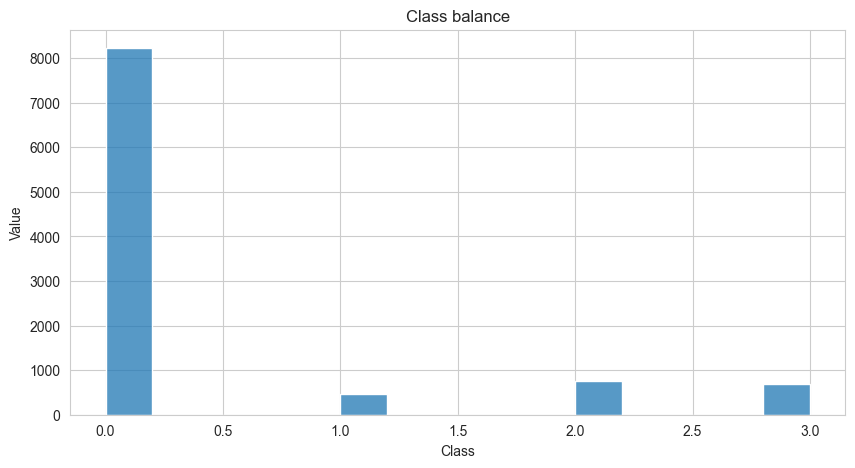

In [150]:
# подсчитаем процентное соотношение для классов
print(pd.DataFrame(data[target].value_counts(normalize=True)*100))

# построим график
plt.subplots(figsize=(10, 5))
sns.histplot(data[target])
plt.title('Class balance')
plt.xlabel('Class')
plt.ylabel('Value')


Наличиствует явный дисбаланс классов, что необходимо учитывать.

## Выбросы (проверка на наличие)

Из описания признаков видно, что несколько столбцов в наборе данных имеют высокое стандартное отклонение. Выбросы влияют на среднее значение. Особенно, если среднее значение мало по сравнению с максимальным значением, что позволяет предположить наличие некоторых выбросов. Визуализируем признаки и выясним - есть ли выбросы, исходя из их природы и значений.

Используем boxplot и рассмотрим однотипные признаки (датчики света, звука, СО2 и движения) рядом, в одном масштабе оси Y.

### Освещенность:

Text(0.5, 0.98, 'Light"s outliers')

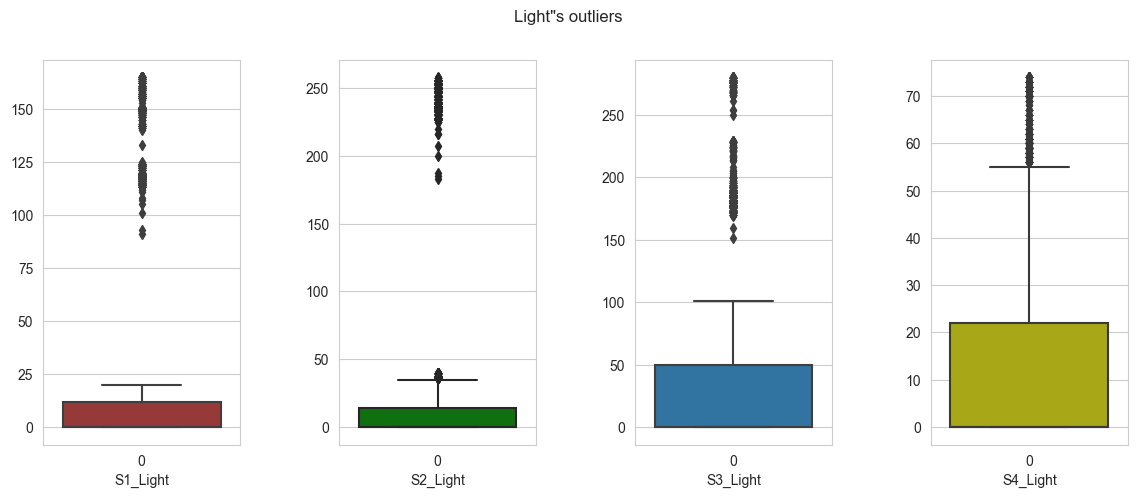

In [151]:
fig, ax = plt.subplots(1, 4, figsize=(14, 5))

plt.subplots_adjust(wspace=0.5)

sns.boxplot(data=data['S1_Light'], ax=ax[0], color='brown')
ax[0].set_xlabel('S1_Light')

sns.boxplot(data=data['S2_Light'], ax=ax[1], color='g')
ax[1].set_xlabel('S2_Light')

sns.boxplot(data=data['S3_Light'], ax=ax[2])
ax[2].set_xlabel('S3_Light')

sns.boxplot(data=data['S4_Light'], ax=ax[3], color='y')
ax[3].set_xlabel('S4_Light')

plt.suptitle('Light"s outliers')


Из графиков видно, что большая часть плотности для этих переменных составляет около 0. Это говорит о том, что в это время нет источника света, что логично, т.к. класс 0 состявляет порядка 80 % от общего количества записей. 

Обычно уровень освещенности в помещении для нормальной деятельности колеблется от 100 до 300 люкс, это означает, что значения выше 75-го процентиля являются значимыми. И они не выходят за границы нормальных значений освещенности.

Т.е. для признаков датчиков света это не выбросы, а нормальные данные.

### СО2:

Text(0.5, 0.98, 'CO2"s outliers')

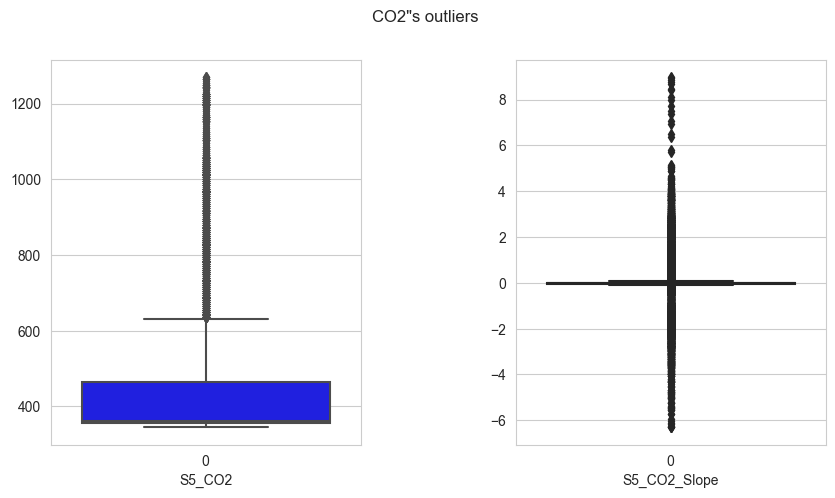

In [152]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plt.subplots_adjust(wspace=0.5)


sns.boxplot(data=data['S5_CO2'], ax=ax[0], color='b')
ax[0].set_xlabel('S5_CO2')

sns.boxplot(data=data['S5_CO2_Slope'], ax=ax[1], color='g')
ax[1].set_xlabel('S5_CO2_Slope')

plt.suptitle('CO2"s outliers')


Уровни CO2, которые считаются типичными:

* 400 ppm – нормальный уровень наружного воздуха.
* 400 - 1100 ppm – типичный уровень значения в помещении с хорошей вентиляцией. Если уровень CO2 низкий, когда здание герметично закрыто и в нем находятся люди, возможна избыточная вентиляция.
* 1100 ppm – рекомендованный максимальный уровень в закрытом помещении.
* 1200 ppm — плохое качество воздуха (требуется вентиляция помещения).
* 2000 ppm - согласно многим исследованиям, этот уровень CO2 приводит к значительному увеличению сонливости, усталости, головным болям, снижению уровня концентрации и увеличению вероятности распространения респираторных вирусов, таких как простуда и т. д.

Отсюда можно сделать вывод, что экстремальные значения уровня CO2 повышают ценность набора данных. Следовательно, выбросы для данного признака отсутствуют. Значения до 1300 ppm - нормальные реальные значения.

Разница СО2:

Изменения в концентрации СО2 между двумя соседними измерениями. Диапазон от -7 (уменьшение на 7 ppm) до 9 (увеличения на 9 ppm). Теоретически, при большем количестве людей колебания концентрации могут быть больше. Выбросы не наблюдаются.

In [153]:
# определим минимум, максимум и среднее
# признака S5_CO2_Slope (разница СО2) для каждого класса
data.groupby(target)['S5_CO2_Slope'].agg(['min', 'mean', 'max'])


,min,mean,max
Room_Occupancy_Count,,,
0,-6.296154,-0.308078,2.961538
1,-3.634615,0.310625,2.800000
2,-2.761538,1.141881,5.138462
3,-0.911538,2.145877,8.980769


Видно, что для каждого класса свой диапазон значений и он несколько меняется с ихменением количества людей в помещении - как по амплитуде, так и по значениям (сдвигаясь вправо по числовой оси). Т.е. этот признак логичный  и значимый для целевой переменной.

### Звук:

Text(0.5, 0.98, 'Sound"s outliers')

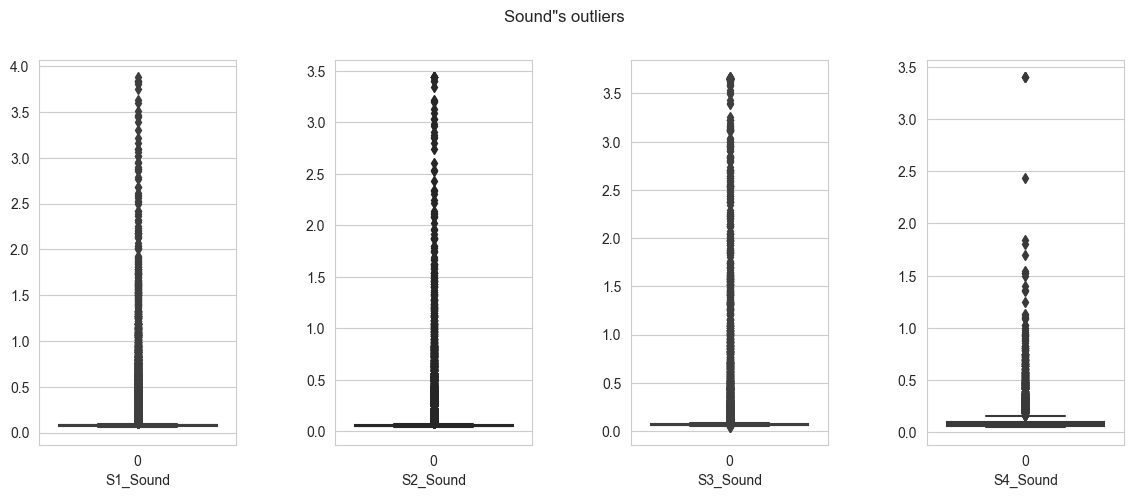

In [154]:
fig, ax = plt.subplots(1, 4, figsize=(14, 5))

plt.subplots_adjust(wspace=0.5)

sns.boxplot(data=data['S1_Sound'], ax=ax[0], color='brown')
ax[0].set_xlabel('S1_Sound')

sns.boxplot(data=data['S2_Sound'], ax=ax[1], color='g')
ax[1].set_xlabel('S2_Sound')

sns.boxplot(data=data['S3_Sound'], ax=ax[2])
ax[2].set_xlabel('S3_Sound')

sns.boxplot(data=data['S4_Sound'], ax=ax[3], color='y')
ax[3].set_xlabel('S4_Sound')

plt.suptitle('Sound"s outliers')


Выбросов нет. Значения всех 4 датчиков звука в пределах от 0 до 4 Вольт, с основной долей в районе нуля (0 класс).

Температура:
    
Выбросы отсутствуют, это видно из миниумов\максимумов\среднего и стандартных отклонений (в сравнении со средним и процентилями ...).

Движение:

Это бинарные признаки, выбросы для них не существуют как сущность.

## Выводы:

Датасет проверен на неинформативные признаки, дубликаты, пропущенные и "ошибочные' значения (нулевые значения) и выбросы. 

Два неинформативных признака исключены. 

Дубликаты присутствуют, однако их исключение нецелесообразно, т.к. они влияют на соотношение количества экземпляров каждого класса (а точнее повышают долю 0 класса). Можно проверить работу моделей при их исключении.

Пропущенные и 'ошибочные' значения отсутствуют (нули - адекватные значения своих параметров). 

Выбросы также отсутствуют, т.к. все значения в нормальных, логичных пределах для соответствующего признака.

Признаки для датчиков движения имеют бинарные значения (0 и 1) и распределение этих значений не совсем логично для всех классов (для классов 1, 2 и 3 вместо 1 в половине случаев присутствует 0, а для признака S7_PIR класс 1 практически полностью имеет значение 0). Необходимо сравнить результаты предсказания моделей без этих признаков и сними, и решить вопрос об исключении.

Присутствует сильный дисбаланс классов (превалирование 0 класса - отсутствие людей в помещении), который необходимо учитывать в дальнейшем.

# **Анализ признаков**

### 1. Взаимосвязь признаков с целевой переменной в разрезе классов.

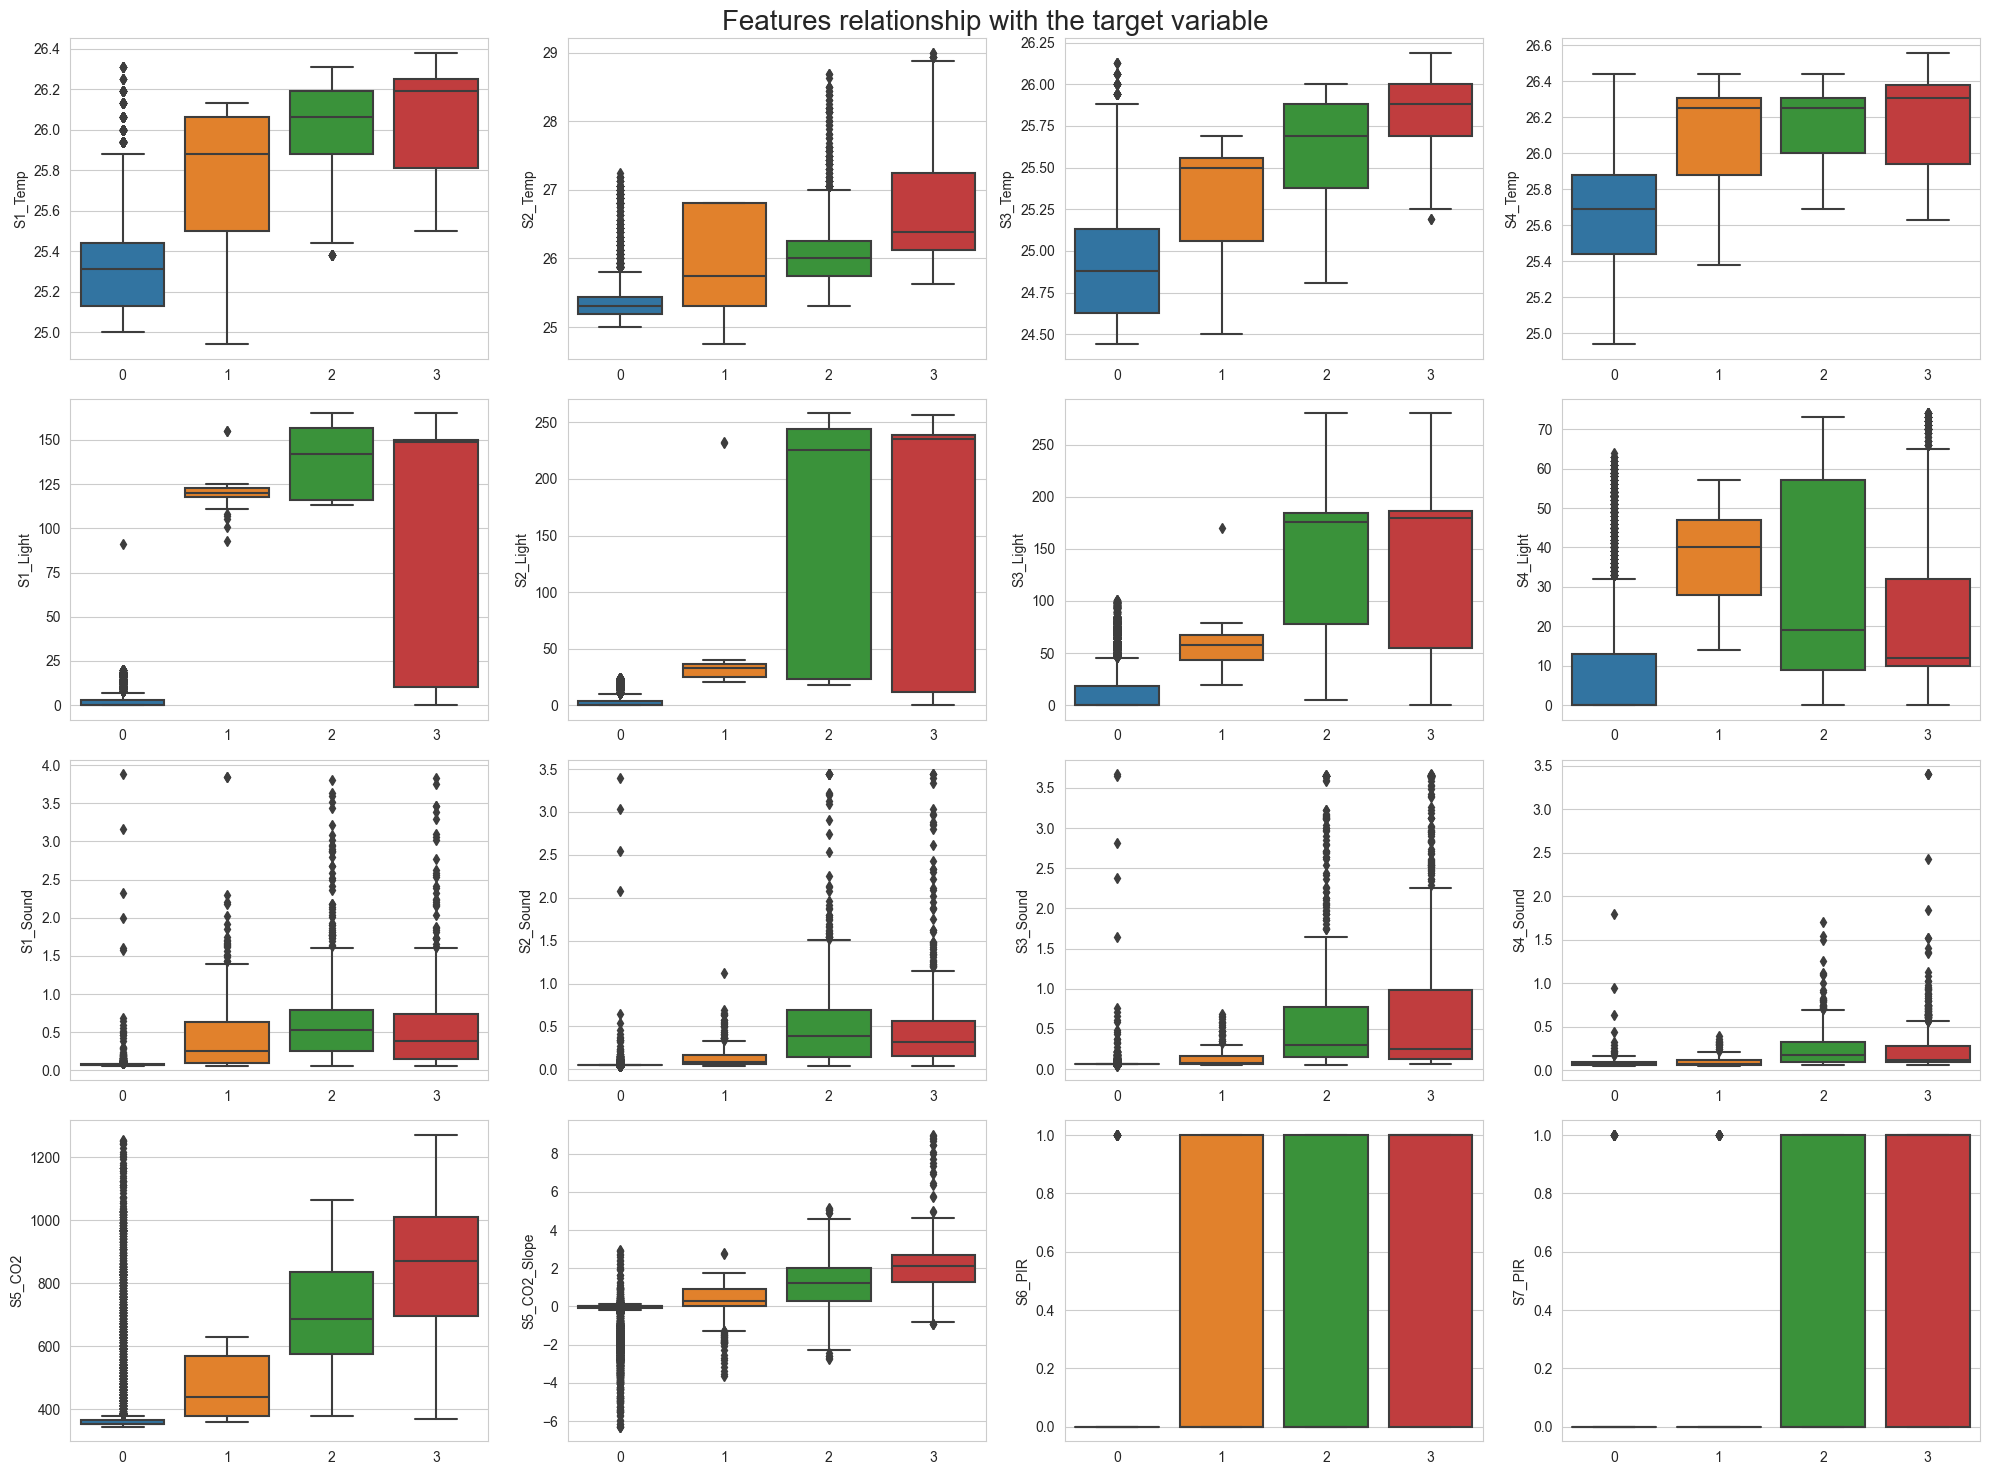

In [155]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
for idx, feat in enumerate(features_list):
    ax = axes[int(idx / 4), idx % 4]
    sns.boxplot(x=target, y=feat, data=data, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel(feat)
fig.suptitle('Features relationship with the target variable', size=20)
fig.tight_layout()


Все графики выглядят адекватно (границы, медианы и т.д.).

Температура растет с увеличением количества людей в помещении. Датчики освещенности также показывают более высокие значения с ростом количества людей. Аналогично в отношении звуковых датчиков и датчика СО2. Некоторые искажения, вероятно связаны с расположением датчиков.

Особенности значений признаков для датчиков движения указаны ранее.

### 2. Распределение признаков (тип)

Проверим нормальность распределения признаков визуально (гистограммы), а также  с помощью теста на отличие выборки от нормального распределения (основан на тесте Д'Агостино и Пирсона).

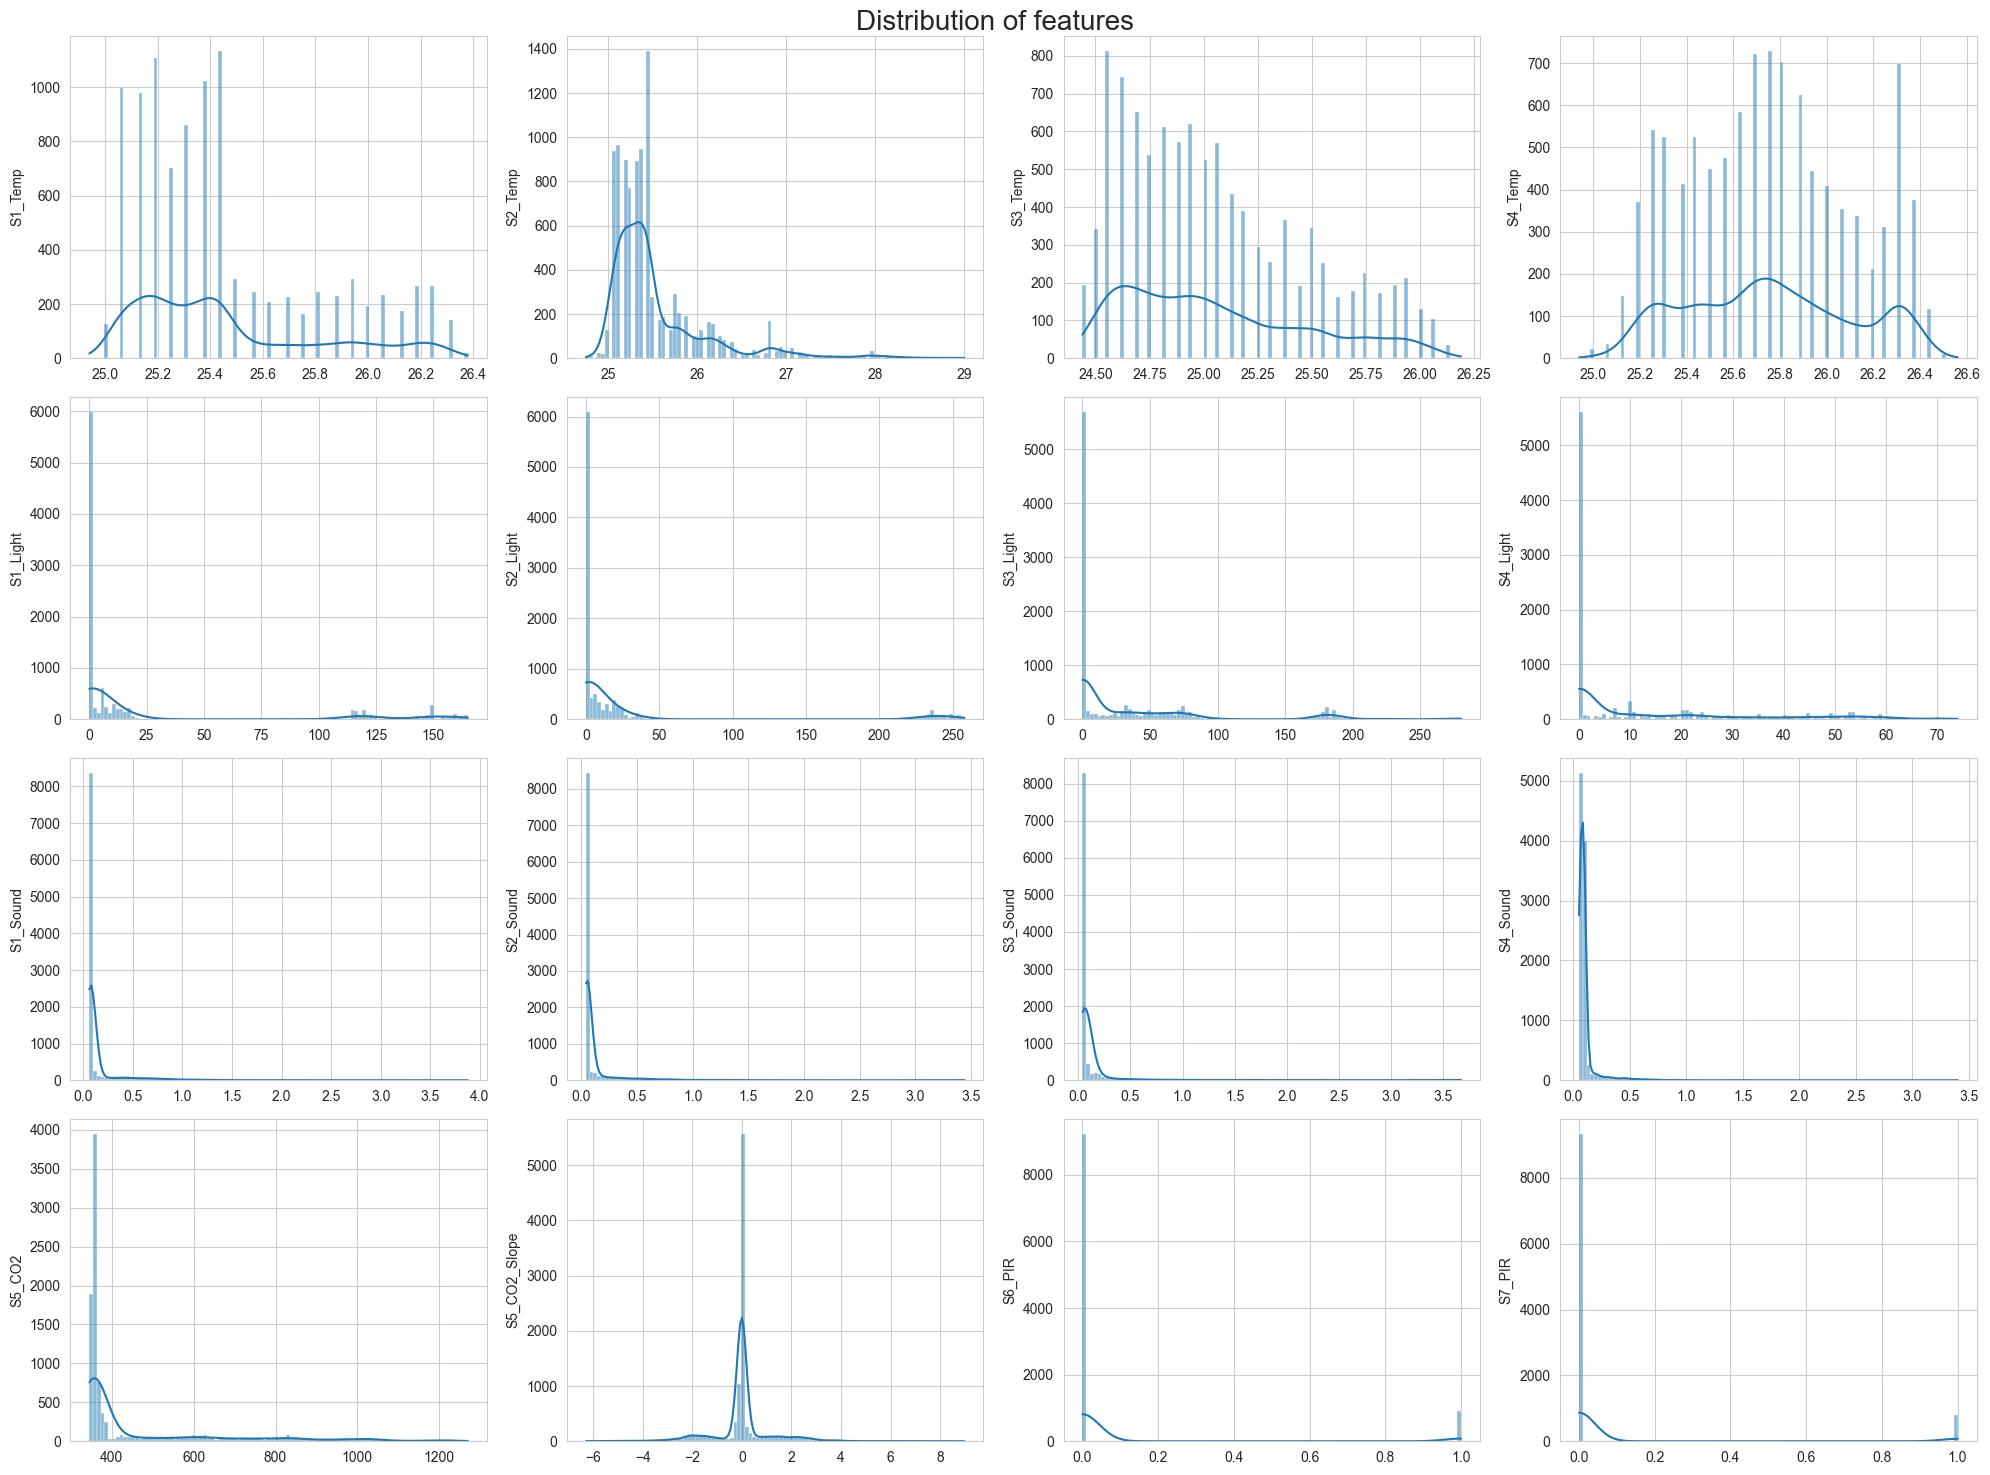

In [156]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
for idx, feat in enumerate(features_list):
    ax = axes[int(idx / 4), idx % 4]
    sns.histplot(data[feat], kde=True, bins=100, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel(feat)
fig.suptitle('Distribution of features', fontsize=20)
fig.tight_layout()


In [157]:
p = 0.001  # уровень значимости (возьмем очень малый, 0.1 %)

for col in features_list:

    _, p_value = normaltest(data[col])
    # будем выводить сообщение только в случае нормального распределения
    if p_value >= p:
        print(
            f'The attribute {col} is normally distributed. P-value = {p_value}')


Очевидно, что данные распределены не нормально. Проверим, что такой же тип распределения присутствиет для выборок признаков по отдельным классам.

In [158]:
p = 0.001  # уровень значимости (возьмем очень малый, 0.1 %)

# в цикле для каждого класса
for num in range(4):
    for col in features_list:
        _, p_value = normaltest(data[col][data[target] == num])
        # будем выводить сообщение только в случае нормального распределения
        if p_value >= p:
            print(
                f'The attribute {col} for class {num} is normally distributed. P-value = {round(p_value, 2)}')


The attribute S5_CO2_Slope for class 2 is normally distributed. P-value = 0.7


Отдельные выборки по классам для всех признаков также не имеют нормального распределения, за исключением признака разницы СО2 для класса 2.

### 3. Парная корреляция признаков

Так как, распределения признаков не являются нормальными для определения степени корреляции будем использовать коэффициент корреляции Спирмена.

Text(0.5, 1, 'Paired correlation between features')

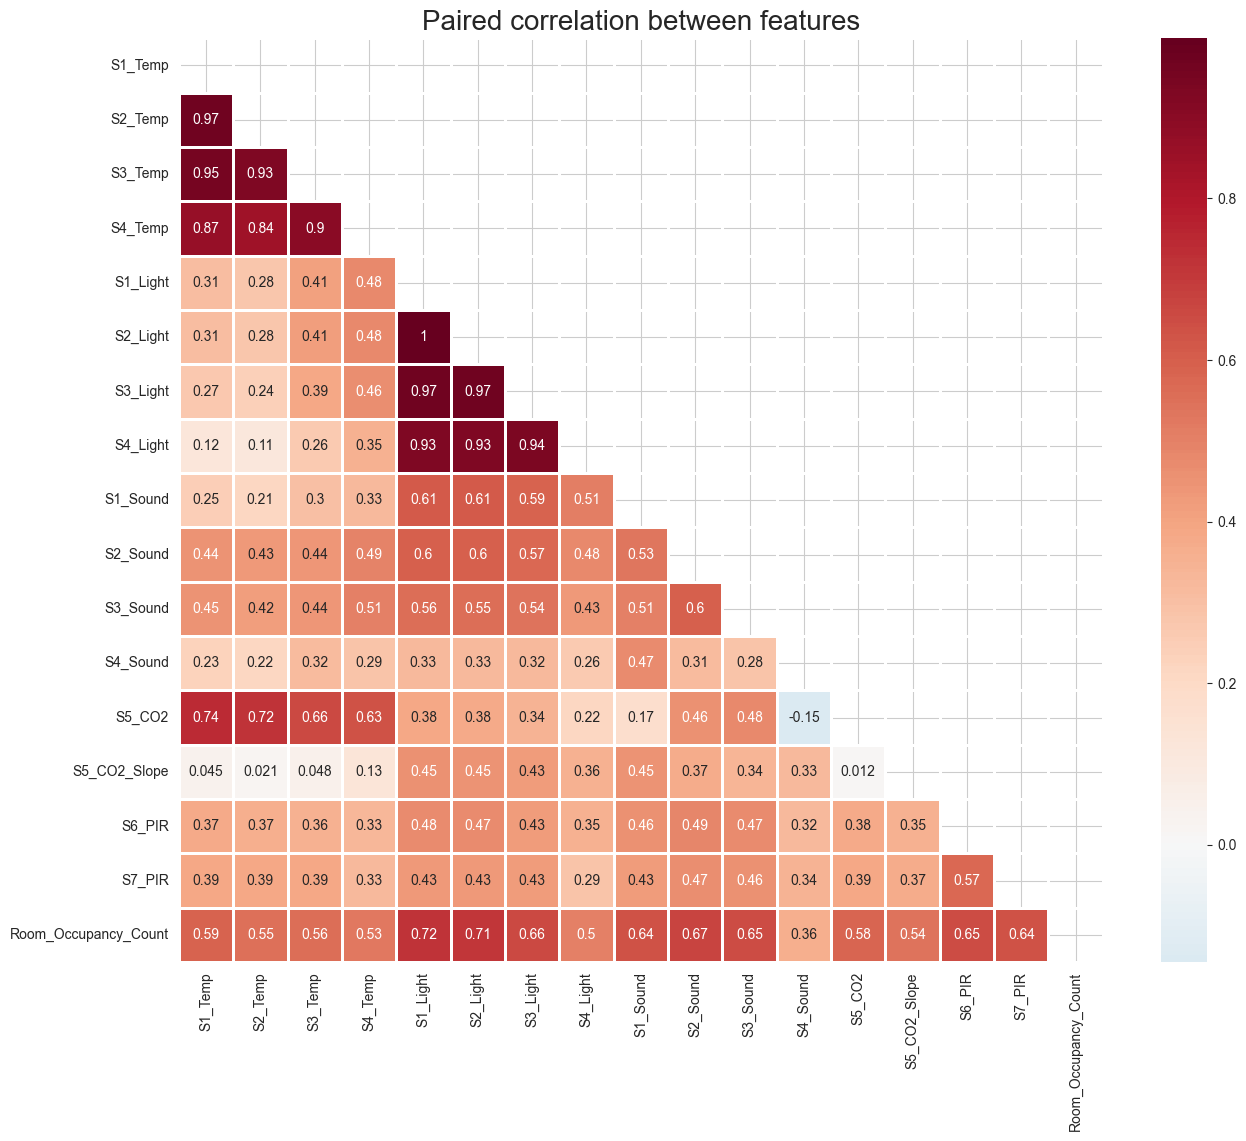

In [159]:
# построим тепловую карту корреляции (парной) признаков
mask = np.zeros_like(data.corr(), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
sns.set_style('whitegrid')
plt.subplots(figsize=(15, 12))
sns.heatmap(data.corr(method='spearman'), annot=True, mask=mask, cmap='RdBu_r',
            linewidths=.9, linecolor='white', fmt='.2g', center=0, square=True)
plt.title('Paired correlation between features', y=1, fontsize=20)


1. Коэффициенты корреляции всех признаков с целевой переменной Room_Occupancy_Count находятся в пределах от 0.36 до 0.72, практически все от 0.5 до 0.7. Т.е. индивидуально (попарно с целевой переменной) все признаки имеют высокую информативность.

2. Присутствуют группы признаков, с очень высокой корреляцией друг с другом, что логично, исходя из физической природы данных. Мультиколлинеарность присутствует в группе признаков температуры (S1_Temp, S2_Temp, S3_Temp, S4_Temp) и группе признаков освещенности (S1_Light, S2_Light, S3_Light, S4_Light) - коэффициент от 0,9 до 1 почти для всех пар.

3. Стоит отметить низкую корреляцию признака S5_CO2_Slope со всеми признаками температуры и признаком саомого уровня CO2.

## Выводы
Данные соответствуют логике и общепринятым физическим концепциям. Некоторые особенности присутствуют у значений признаков для датчиков движения.

Данные распределены не нормально. 

Матрица корреляции показывет, что с целевой переменной признаки коррелируют с коэффициентами не менее 0.5 (большинство), т.е. имеют достаточно высокую информативность. Кроме того, присутствует мультиколлинеарность для групп признаков температуры и признаков освещенности (коэффициент корреляции от 0,9 до 1 почти для всех пар).

Очевидно, что возможно существенно уменьшить размерность пространства признаков (их количество) с сохранением содержащейся в них информации.


# **Подготовка данных**

Для работы с признаками (отбор, снижение размерности и т.д. ), а так же для их использования в моделях произведем следующие преобразования: 

* разделим данные на признаки и целевую переменную
* заменим представление данных dataframe на массивы numpy

In [160]:
# выделим признаки и целевую переменную
X = data[features_list]
y = data[target]

# заменим dataframe на массив numpy
X = X.values
y = y.values


Разделим набор признаков и целевую переменную на тренировочную и тестовую выборки. Пропорцию деления выберем по 0.5 для тренировочной и тестовой выборок. Такую сравнительно большую долю тестовой выборки возьмем для того, чтобы максимально качественно оценить работу моделей. Также учтем дисбаланс классов.

In [161]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y)

print('Train X', X_train.shape)
print('Test X', X_test.shape)
print('Train y', y_train.shape)
print('Test y', y_test.shape)


Train X (5064, 16)
Test X (5065, 16)
Train y (5064,)
Test y (5065,)


Стандартизируем отдельно тренировочную и тестовую выборки и отдельно весь набор признаков (необходимо для методов уменьшения размерности и т.д.).

In [162]:
# стандартизируем тренировочную и тестовую выборки
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# стандартизируем весь набор признаков
X = scaler.fit_transform(X)


# **Функция вычисления метрик моделей**

Функция будет принимать название модели, истинные и предсказанные значения целевой переменной. Затем вычислять взвешенные значения метрик (т.е. среднее для всех классов, с учетом соотношения их размеров): accuracy, precision, recall, f1. А также значения метрики f1 для всех четырех классов, сумму ошибочных значений для всех классов (т.е. сумму всех ошибок модели на конкретном предсказании) и процентную долю суммы ошибок для всех классов от объема тестовой выборки. Далее функция будет добавлять название модели, значения метрик, суммы ошибок и процентной доли суммы ошибок в тестовой выборке к таблице результатов df_result снизу и возвращать обновленную таблицу результатов df_result. Также будет выводиться текстовый отчет результатов классификации classification_report для текущей модели.

In [163]:
# инициализируем таблицу результатов пустым датафреймом
df_result = pd.DataFrame()


def metrics_score(model, y_test, y_pred):
    """
    The function calculates weighted values of several metrics:
    accuracy, precision, recall, f1,
    adds them to the df_result results table
    and outputs a text report of classification results
    classification_report for the current model.

    Args:
        model (str): model name.
        y_test (1d array-like, or label indicator array / sparse matrix):
            ground truth (correct) target values.
        y_pred (1d array-like, or label indicator array / sparse matrix):
            estimated targets as returned by a classifier.

    Returns:
        Updated df_result results table
        with the added row of results of the current model.

    """
    # вычисляем взвешенные значения всех метрик
    accuracy = accuracy_score(y_test, y_pred)
    weighted_precision = precision_score(y_test, y_pred, average='weighted')
    weighted_recall = recall_score(y_test, y_pred, average='weighted')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    # заносим взвешенные значения метрик в датафрейм
    weighted_add = pd.DataFrame([[model,
                                  round(accuracy, 5),
                                  round(weighted_precision, 5),
                                  round(weighted_recall, 5),
                                  round(weighted_f1, 5)
                                  ]],
                                columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

    # вычисляем значения метрики f1
    # для каждого класса по отдельности и заносим в датафрейм
    f1_class_add = pd.DataFrame([f1_score(y_test, y_pred, average=None)],
                                columns=['f1_0', 'f1_1', 'f1_2', 'f1_3'])

    # объединяем все вычисленные значения метрик
    df_add = weighted_add.join(f1_class_add)

    # вычисляем сумму элементов матрицы ошибок вне
    # главной диагонали (т.е. сумму всех ошибок классификации)
    # и добавляем в датафрейм
    cm = confusion_matrix(y_test, y_pred)
    df_add['error'] = np.sum(cm) - np.trace(cm)

    # вычисляем процентную долю суммы ошибочных значений
    # для всех классов от объема тестовой выборки и добавляем в датафрейм
    df_add['% error %'] = (df_add['error'] / len(y_test)) * 100

    # выводим текстовый отчет
    # результатов классификации classification_report
    print(classification_report(y_test, y_pred))

    # выводим обновленную таблицу результатов
    # (с добавленной строкой значений метрик и
    # количеством ошибочных значений)
    return pd.concat([df_result, df_add], ignore_index=True)


# Построение модели (полный набор признаков)

Построим три модели МО для предсказания присутствия и количества присутствующих людей в помещении. 
1. Baseline. Используем модель логистической регрессии с полным набором признаков и параметрами по умолчанию.
2. Baseline_plus. Используем модель логистической регрессии с полным набором признаков и подбором гиперпараметров.
3. Продвинутая модель. Будем использовать ансамбль решающих деревьев с полным набором признаков и подбором гиперпараметров.
4. Продвинутая модель. Будем использовать LightGBM с полным набором признаков и подбором гиперпараметров.

Дополнительно, кроме полного набора признаков оценим работу моделей на очищенных от дубликатов признаках и с 2 удаленными признаками движения. С целью выяснения влияния их присутствия (дубликатов в классе 0 и признаков движения) на качество работы моделей.

### 1. Логистическая регрессия (параметры по умолчанию)

In [164]:
# инициализируем модель логистической регрессии
lr = LogisticRegression(random_state=42,
                        n_jobs=-1,
                        class_weight='balanced')

# обучим ее
lr.fit(X_train, y_train)

# осуществим предсказание
y_pred_lr = lr.predict(X_test)

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('LogisticRegression (full features)',
                          y_test,
                          y_pred_lr)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4114
           1       1.00      1.00      1.00       230
           2       0.97      0.97      0.97       374
           3       0.94      0.96      0.95       347

    accuracy                           0.99      5065
   macro avg       0.98      0.98      0.98      5065
weighted avg       0.99      0.99      0.99      5065



Построим матрицу ошибок и визуализируем ее.

Text(45.722222222222214, 0.5, 'Actual/Observed')

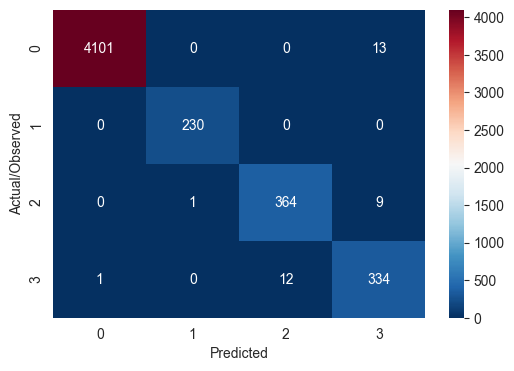

In [165]:
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


### 2. Логистическая регрессия
Подбор гиперпараметров с помощью GridSearchCV. В качестве метрики для подбора гиперпараметров будет использоваться f1_weighted, а для оценки модели с лучшими параметрами - classification_report.

In [166]:
# зададим сетку параметров
param_grid = [
    {
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'C': [0.1, 0.5, 1, 3, 7, 10, 20, 30, 50],
        'class_weight': ['balanced'],
        'max_iter': [100]
    },
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'C': [0.1, 0.5, 1, 3, 7, 10, 20, 30, 50],
        'class_weight': ['balanced'],
        'max_iter': [100]
    }
]

# инициализируем модель логистической регрессии
lr = LogisticRegression(random_state=42, n_jobs=-1)

# инициализируем модель подбора гиперпараметров по сетке
gs = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=5
)

# осуществим подбор гиперпараметров
# для тренировочных выборок признаков и целевой переменной
gs.fit(X_train, y_train)

print(f'Best parameters: {gs.best_params_}')

# осуществим предсказание с лучшими параметрами
y_pred_lr = gs.predict(X_test)

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('LogisticRegression plus (full features)',
                          y_test,
                          y_pred_lr)


Best parameters: {'C': 7, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4114
           1       1.00      1.00      1.00       230
           2       0.97      0.98      0.98       374
           3       0.96      0.97      0.96       347

    accuracy                           1.00      5065
   macro avg       0.98      0.99      0.98      5065
weighted avg       1.00      1.00      1.00      5065



Построим матрицу ошибок и визуализируем ее.

Text(45.722222222222214, 0.5, 'Actual/Observed')

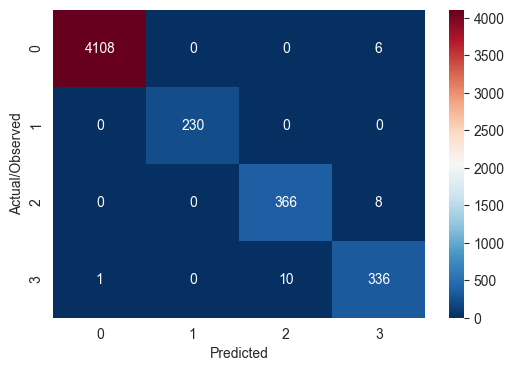

In [167]:
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


Зафиксируем лучшие параметры для логистической регрессии и добавим в набор значения для random_state и n_jobs.

In [168]:
lr_param = gs.best_params_

lr_param['random_state'] = 42
lr_param['n_jobs'] = -1

print(f'Parameters: {lr_param}')


Parameters: {'C': 7, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg', 'random_state': 42, 'n_jobs': -1}


### 3. Классификатор случайного леса
Подбор гиперпараметров с помощью GridSearchCV. В качестве метрики для подбора гиперпараметров будет использоваться f1_weighted, а для оценки модели с лучшими параметрами - classification_report.

In [169]:
# зададим сетку параметров
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 20, 30, 50]
}

# инициализируем модель классификатора случайного леса
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# инициализируем модель подбора гиперпараметров по сетке
gs = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=5
)

# осуществим подбор гиперпараметров
# для тренировочных выборок признаков и целевой переменной
gs.fit(X_train, y_train)

print(f'Best parameters: {gs.best_params_}')

# осуществим предсказание с лучшими параметрами
y_pred_rf = gs.predict(X_test)

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('RandomForestClassifier (full features)',
                          y_test,
                          y_pred_rf)


Best parameters: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 1000}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4114
           1       0.99      1.00      1.00       230
           2       0.99      0.98      0.99       374
           3       0.99      0.98      0.99       347

    accuracy                           1.00      5065
   macro avg       0.99      0.99      0.99      5065
weighted avg       1.00      1.00      1.00      5065



Построим матрицу ошибок и визуализируем ее.

Text(45.722222222222214, 0.5, 'Actual/Observed')

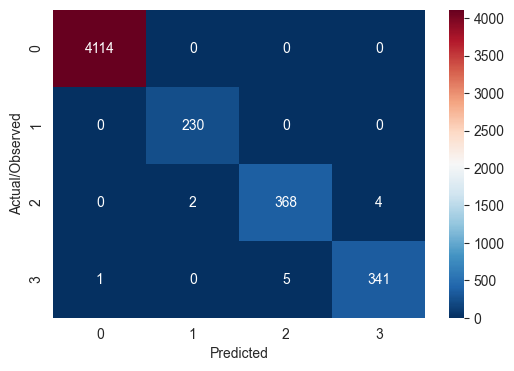

In [170]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


Зафиксируем лучшие параметры для классификатора случайного леса и добавим в набор значения для random_state и n_jobs.

In [171]:
rfc_param = gs.best_params_
rfc_param['random_state'] = 42
rfc_param['n_jobs'] = -1

print(f'Parameters: {rfc_param}')


Parameters: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 1000, 'random_state': 42, 'n_jobs': -1}


### 4. LightGBM
Подбор гиперпараметров с помощью Optuna. В качестве метрики для подбора гиперпараметров будет использоваться f1_weighted, а для оценки модели с лучшими параметрами - classification_report.

In [172]:
# определим функцию подбора гиперпараметров, будем
# использовать весь набор записей и кросс-валидацию
# с усреднением результата
def objective(trial):
    # задаем константы и диапазоны подбора
    # для параметров модели
    params = {
        'objective': 'multiclass',
        'num_class': 4,
        'verbosity': -1,
        'num_threads': 12,
        'random_seed': 42,
        'boosting_type': 'gbdt',
        'class_weight': 'balanced',
        'max_bin': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.00001, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 1, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500)
    }
    # инициализация модели с конкретным набором параметров
    clf = lgb.LGBMClassifier(**params)
    # подсчет значения метрики путем перекрестной оценки, вывод -
    # массив из 5 значений (т.к. 5-кратная перекрестная проверка)
    scores = cross_val_score(
        clf, X, y, scoring='f1_weighted', cv=KFold(n_splits=5, shuffle=True))
    # вывод текущих гиперпараметров и среднего результата
    report_cross_validation_scores(trial, scores)
    # вывод среднего значения метрики
    return scores.mean()


# cоздаем объект optuna, указав максимизацию метрики
# direction="maximize", также укажем количество прогонов
# подбора и автоматический терминатор оптимизации
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, callbacks=[TerminatorCallback()])

print(f'The number of trials: {len(study.trials)}')
print(f'Best value: {study.best_value} (params: {study.best_params})')

# зафиксируем готовый набор гиперпараметров
# (как заранее определенных, так и подобранных)
params = {'objective': 'multiclass',
          'num_class': 4,
          'verbosity': -1,
          'num_threads': 12,
          'random_seed': 42,
          'boosting_type': 'gbdt',
          'class_weight': 'balanced',
          'max_bin': 1000}

lgbm_param = params | study.best_params

# инициализируем модель и обучим на тренировчном наборе
# с подобранными гиперпараметрами
model = lgb.LGBMClassifier(**lgbm_param, num_boost_round=1000)
model.fit(X_train, y_train)

# осуществим предсказание с лучшими параметрами
y_pred_lgbm = model.predict(X_test)

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('LGBM (full features)',
                          y_test,
                          y_pred_lgbm)


[I 2023-10-23 03:28:19,112] A new study created in memory with name: no-name-b35f518e-fe80-42d7-8712-f4fcbe50eb39
[I 2023-10-23 03:28:32,322] Trial 0 finished with value: 0.9975298029304642 and parameters: {'learning_rate': 0.015629038119677464, 'num_leaves': 90, 'max_depth': 10, 'n_estimators': 486}. Best is trial 0 with value: 0.9975298029304642.
[I 2023-10-23 03:28:33,755] Trial 1 finished with value: 0.9973355384695154 and parameters: {'learning_rate': 0.0821571044846908, 'num_leaves': 301, 'max_depth': 4, 'n_estimators': 187}. Best is trial 0 with value: 0.9975298029304642.
[I 2023-10-23 03:28:35,169] Trial 2 finished with value: 0.9976299064794103 and parameters: {'learning_rate': 0.07397284259296229, 'num_leaves': 41, 'max_depth': 5, 'n_estimators': 135}. Best is trial 2 with value: 0.9976299064794103.
[I 2023-10-23 03:28:38,445] Trial 3 finished with value: 0.9972354673824407 and parameters: {'learning_rate': 0.02304063329059831, 'num_leaves': 18, 'max_depth': 15, 'n_estimators

The number of trials: 21
Best value: 0.9976299064794103 (params: {'learning_rate': 0.07397284259296229, 'num_leaves': 41, 'max_depth': 5, 'n_estimators': 135})
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4114
           1       0.98      1.00      0.99       230
           2       0.99      0.97      0.98       374
           3       0.98      0.98      0.98       347

    accuracy                           1.00      5065
   macro avg       0.99      0.99      0.99      5065
weighted avg       1.00      1.00      1.00      5065



Построим матрицу ошибок и визуализируем ее.

Text(45.722222222222214, 0.5, 'Actual/Observed')

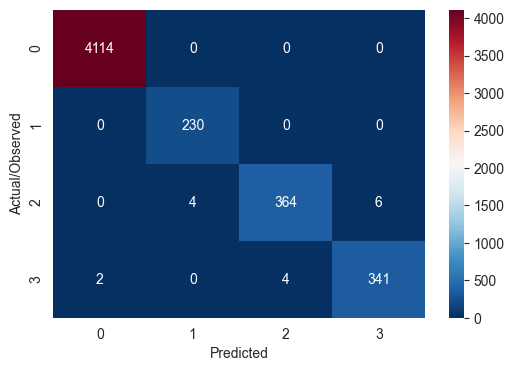

In [173]:
cm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


## Усеченные данные
Оценим влияние дубликатов и признаков, содержащих информацию от двух датчиков движения. Т.е применим все три модели с подобранными гиперпараметрами к набору признаков с удаленными дубликатами и удаленными признаками движения, по отдельности. 

Подготовим набор признаков с удаленными дубликатами.

In [174]:
# удалим дубликаты
data_dd = data.drop_duplicates()
print(f'Shape of unduplicated data: {data_dd.shape}')

# выделим признаки и целевую переменную,
X_dd = data_dd[features_list]
y_dd = data_dd[target]

# разделим на тренировочную и тестовую выборки
X_train_dd, X_test_dd, y_train_dd, y_test_dd = train_test_split(
    X_dd, y_dd, test_size=0.5, random_state=42, stratify=y_dd)

# стандартизируем тренировочную и тестовую выборки
scaler = StandardScaler()
scaler.fit(X_train_dd)
X_train_dd = scaler.transform(X_train_dd)
X_test_dd = scaler.transform(X_test_dd)


Shape of unduplicated data: (8828, 17)


### 5. Классификатор случайного леса (без дубликатов)

In [175]:
# используем классификатор случайного леса
rf = RandomForestClassifier(**rfc_param)
rf.fit(X_train_dd, y_train_dd)
y_pred_dd = rf.predict(X_test_dd)

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('RandomForestClassifier (full featuers, unduplicated)',
                          y_test_dd,
                          y_pred_dd)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3464
           1       0.99      0.99      0.99       229
           2       0.99      0.98      0.98       374
           3       0.98      0.99      0.99       347

    accuracy                           1.00      4414
   macro avg       0.99      0.99      0.99      4414
weighted avg       1.00      1.00      1.00      4414



Построим матрицу ошибок и визуализируем ее.

Text(45.722222222222214, 0.5, 'Actual/Observed')

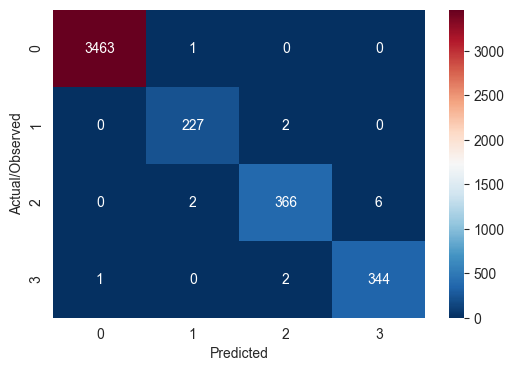

In [176]:
cm = confusion_matrix(y_test_dd, y_pred_dd)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


### 6. Логистическая регрессия (без дубликатов)

In [177]:
# используем модель логистической регрессии
# с ранее подобранными гиперпараметрами
lr = LogisticRegression(**lr_param)
lr.fit(X_train_dd, y_train_dd)
y_pred_dd = lr.predict(X_test_dd)

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('LogisticRegression plus (full featuers, unduplicated)',
                          y_test_dd,
                          y_pred_dd)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3464
           1       0.99      0.99      0.99       229
           2       0.98      0.97      0.97       374
           3       0.96      0.98      0.97       347

    accuracy                           0.99      4414
   macro avg       0.98      0.98      0.98      4414
weighted avg       0.99      0.99      0.99      4414



Построим матрицу ошибок и визуализируем ее.

Text(45.722222222222214, 0.5, 'Actual/Observed')

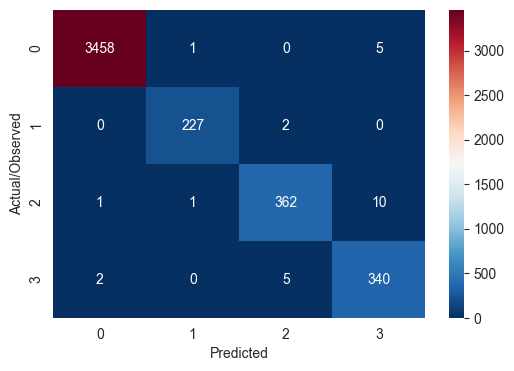

In [178]:
cm = confusion_matrix(y_test_dd, y_pred_dd)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


### 7. LightGBM (без дубликатов)

In [179]:
# используем LightGBM с ранее
# подобранными гиперпараметрами
model = lgb.LGBMClassifier(**lgbm_param, num_boost_round=1000)
model.fit(X_train_dd, y_train_dd)
y_pred_dd = model.predict(X_test_dd)

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('LGBM (full featuers, unduplicated)',
                          y_test_dd,
                          y_pred_dd)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3464
           1       0.99      0.99      0.99       229
           2       0.99      0.98      0.99       374
           3       0.99      0.99      0.99       347

    accuracy                           1.00      4414
   macro avg       0.99      0.99      0.99      4414
weighted avg       1.00      1.00      1.00      4414



Построим матрицу ошибок и визуализируем ее.

Text(45.722222222222214, 0.5, 'Actual/Observed')

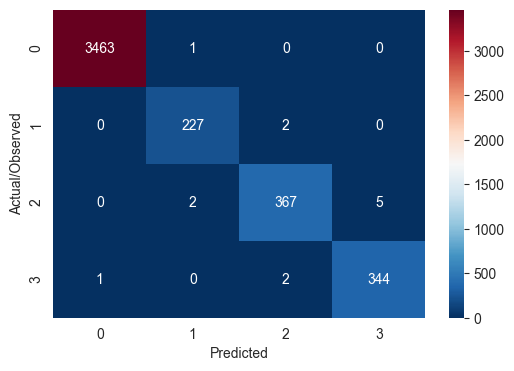

In [180]:
cm = confusion_matrix(y_test_dd, y_pred_dd)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


### 8. Классификатор случайного леса (без признаков движения)

In [181]:
# используем классификатор случайного леса
rf = RandomForestClassifier(**rfc_param)
rf.fit(X_train[:, :-2], y_train)
y_pred_un = rf.predict(X_test[:, :-2])

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('RandomForestClassifier (14 featuers)',
                          y_test,
                          y_pred_un)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4114
           1       0.99      1.00      1.00       230
           2       0.99      0.98      0.99       374
           3       0.99      0.98      0.99       347

    accuracy                           1.00      5065
   macro avg       0.99      0.99      0.99      5065
weighted avg       1.00      1.00      1.00      5065



Построим матрицу ошибок и визуализируем ее.

Text(45.722222222222214, 0.5, 'Actual/Observed')

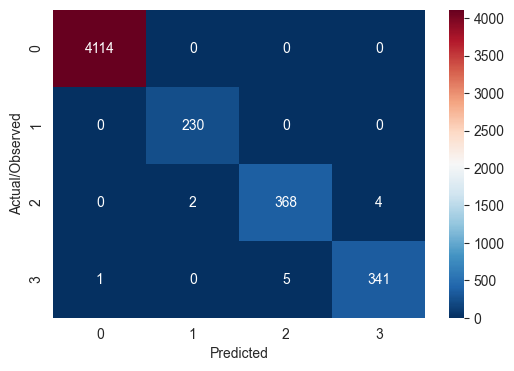

In [182]:
cm = confusion_matrix(y_test, y_pred_un)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


### 9. Логистическая регрессия (без признаков движения)

In [183]:
# используем модель логистической регрессии
# с ранее подобранными гиперпараметрами
lr = LogisticRegression(**lr_param)
lr.fit(X_train[:, :-2], y_train)
y_pred_un = lr.predict(X_test[:, :-2])

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('LogisticRegression plus (14 features)',
                          y_test,
                          y_pred_un)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4114
           1       1.00      1.00      1.00       230
           2       0.97      0.98      0.97       374
           3       0.97      0.97      0.97       347

    accuracy                           1.00      5065
   macro avg       0.98      0.99      0.98      5065
weighted avg       1.00      1.00      1.00      5065



Построим матрицу ошибок и визуализируем ее.

Text(45.722222222222214, 0.5, 'Actual/Observed')

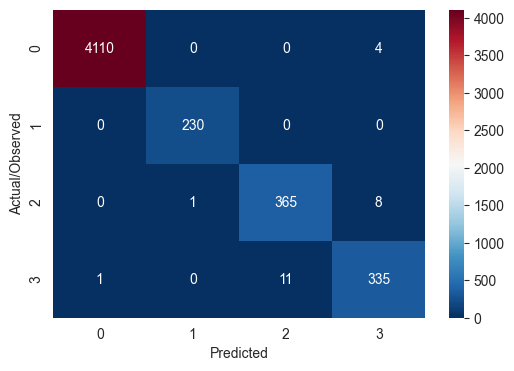

In [184]:
cm = confusion_matrix(y_test, y_pred_un)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


### 10. LightGBM (без признаков движения)

In [185]:
# используем LightGBM с ранее
# подобранными гиперпараметрами
model = lgb.LGBMClassifier(**lgbm_param, num_boost_round=1000)
model.fit(X_train[:, :-2], y_train)
y_pred_un = model.predict(X_test[:, :-2])

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('LGBM (14 features)',
                          y_test,
                          y_pred_un)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4114
           1       0.98      1.00      0.99       230
           2       0.99      0.97      0.98       374
           3       0.98      0.99      0.98       347

    accuracy                           1.00      5065
   macro avg       0.99      0.99      0.99      5065
weighted avg       1.00      1.00      1.00      5065



Построим матрицу ошибок и визуализируем ее.

Text(45.722222222222214, 0.5, 'Actual/Observed')

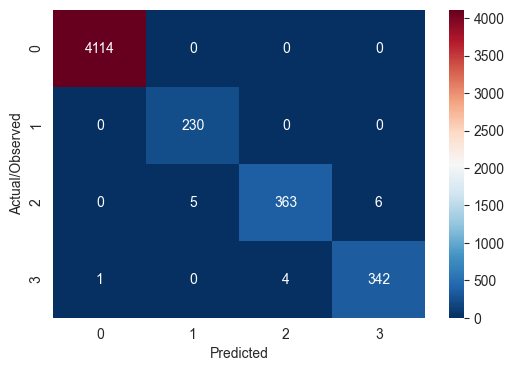

In [186]:
cm = confusion_matrix(y_test, y_pred_un)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


## Выводы
Использования логистической регрессии с параметрами по умолчанию - дает приемлемый результат. Использование логистической регрессии с подобранными гиперпараметрами - лучше. При условии обучения модели на всей совокупности признаков.

Ожидаемо, алгоритм классификатора случайного леса предсказывает лучше, чем логистическая регрессия при использовании всех параметров. Следует отметить, что разница не велика, что связано с характером данных - хорошая корреляция всех признаков с целевой переменной, высокая корреляция признаков друг с другом. Определение класса 0 более точное, чем классов 1, 2 и 3 - тоже объяснимо. Дисбаланс классов: классы 1, 2 и 3 в сумме составляют менее 20 % записей.

Аналогично, градиентный бустинг на примере LigtGBM показывает результат лучше, чем логистическая регрессия, но все же чуть хуже классификатора случайного леса. Качество предсказания по классам остается таким же.

Дополнительно проверено, что удаление дубликатов вызывает, очень небольшое, но все-таки ухудшение качества предсказания алгоритма. Кроме LigtGBM, у которого результат даже лучше.

Дополнительно проверено, что удаление признаков движения не оказывает влияния на результат предсказания (проверено на всех моделях). Эти два признака принципиально малоинформативны, что было очевидно ранее, исходя из логических рассуждений о природе информации данных признаков. Однако удалять их перед уменьшением размерности не следует, т.к. некоторою информацию они все-таки содержат.

# **Выбор признаков**

## Уменьшение размерности (проекция признаков)

Одним из вариантов подготовки набора данных для использования в обучении модели МО является уменьшение размерности методами проекции признаков - преобразования данных из пространства высокой размерности к пространству малой размерности. Это преобразование набора данных, состоящее в уменьшении числа переменных путём получения главных переменных. Преобразование данных может быть линейным, как в методе главных компонент (PCA) и факторном анализе (FA), но существует большое число техник нелинейного понижения размерности, например, UMAP.

Для уменьшения размерности пространства признаков будем использовать факторный анализа (FA), метод главных компонент (PCA) и приближение и проекцию равномерного многообразия (UMAP).

Разница между PCA и FA:

* Компоненты PCA отвечают за наибольшую дисперсию, факторный анализ учитывает ковариацию данных.
* Компоненты PCA полностью ортогональны друг другу, факторы факторного анализа не обязательно должны быть ортогональными.
* Наблюдаемые переменные в компоненте PCA представляют собой линейные комбинации наблюдаемой переменной, наблюдаемые переменные в компоненте FA представляют собой линейные комбинации невидимой переменной или фактора.
* Компоненты PCA сложно интерпретировать. Базовые компоненты FA можно интерпретировать.
* PCA — это метод уменьшения размерности, факторный анализ — это метод анализа скрытых переменных.

UMAP (алгоритм нелинейного снижения размерности) относительно PCA сохраняет мелкие детали в данных.

### 1. FA

Используя наблюдаемую корреляционную матрицу в сравнении с единичной матрицей, тест сферичности Бартлетта определяет, коррелируют ли вообще наблюдаемые переменные. Не следует использовать факторный анализ, если результаты теста оказались статистически незначимыми.

In [187]:
_, p_value = calculate_bartlett_sphericity(X)

print(f'p_value = {p_value}')


p_value = 0.0


Значение p в этом тесте Бартлетта равно 0. Анализ подтвердил, что наблюдаемая корреляционная матрица не является единичной матрицей.

Тест Кайзера-Мейера-Олкина (КМО) показывает в какой степени каждая наблюдаемая переменная прогнозируется без ошибок другими переменными в наборе данных. Соответственно, он определяет, подходят ли данные для факторного анализа. Значения KMO варьируются от 0 до 1 и значение менее 0,6 считается недостаточным.

In [188]:
_, kmo_model = calculate_kmo(X)

kmo_model.round(3)


0.863

Для имеющихся признаков KMO равен 0,86. Это число означает, что факторный анализ может быть осуществлен.

Критерий Кайзера и график "каменистой осыпи" можно использовать для определения количества факторов. В обоих случаях используются собственные значения.

Text(0, 0.5, 'Eigenvalue')

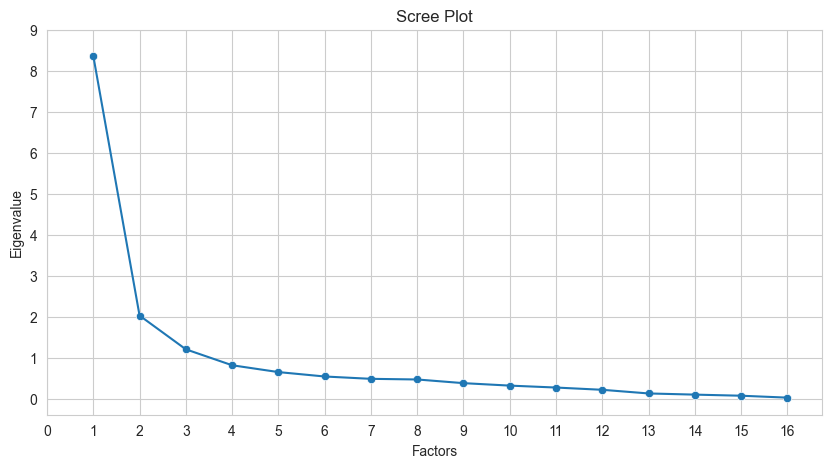

In [189]:
# инициализируем и применим модель факторного анализа
fa = FactorAnalyzer()

fa.fit(X)

# определим собственные значения с учетом матрицы корреляции факторов
ev, _ = fa.get_eigenvalues()

# построим график зависимости величины собственного значения от количества факторов
plt.subplots(figsize=(10, 5))
sns.scatterplot(x=range(1, len(ev)+1), y=ev)
sns.lineplot(x=range(1, len(ev)+1), y=ev)
# укажем название графика, осей, шаг по осям
plt.xticks(np.arange(0, len(ev)+1))
plt.yticks(np.arange(0, 10))
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')


Для каждого фактора на графике указана величина его собственного значения и они соединены. Подходящее количество факторов определяется при условии, что их собственные значения больше единицы (критерий Кайзера) и точкой максимального замедления убывания собственных значений слева направо (критерий "каменистой осыпи").

Как видно, это случай с двумя факторами (собственное значения больше единицы и максимального замедления убывания собственных значений). Это означает, что нужно выбрать 2 фактора.

Определим какой вклад от каждого признака в каждый фактор. А также, какой объем куммулятивной дисперсии обьясняют этот набор факторов (2 штуки).

In [190]:
# задаем количество факторов = 2 для модели факторного анализа
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(X)

# вычисляем доли признаков в каждом факторе
print(pd.DataFrame(fa.loadings_, index=features_list))

# вычисляем информацию о дисперсии каждого фактора
# (включая полную, пропорциональную и куммулятивную)
pd.DataFrame(fa.get_factor_variance(),
             index=['Variance', 'Proportional Var', 'Cumulative Var'])


                     0         1
S1_Temp       0.265917  0.943598
S2_Temp       0.391358  0.741667
S3_Temp       0.207605  0.951598
S4_Temp       0.205327  0.832724
S1_Light      0.719420  0.508601
S2_Light      0.700088  0.417382
S3_Light      0.652402  0.536947
S4_Light      0.389060  0.236847
S1_Sound      0.662445  0.250708
S2_Sound      0.684891  0.192284
S3_Sound      0.639709  0.263332
S4_Sound      0.644549  0.176320
S5_CO2        0.278173  0.809920
S5_CO2_Slope  0.605400 -0.028147
S6_PIR        0.626007  0.280539
S7_PIR        0.639868  0.305388


,0,1
Variance,4.871604,4.845691
Proportional Var,0.304475,0.302856
Cumulative Var,0.304475,0.607331


Видно, что в один фактор основной вклад вносят признаки температуры и СО2 . Во второй фактор - признаки освещенности, звука, разницы СО2 и движения.

61 % куммулятивной дисперсии объясняется двумя факторами.

### 2. PCA

Используем те же данные, что для факторного анализа (весь набор признаков).

Text(0.5, 1.0, 'The number of components needed to explain variance')

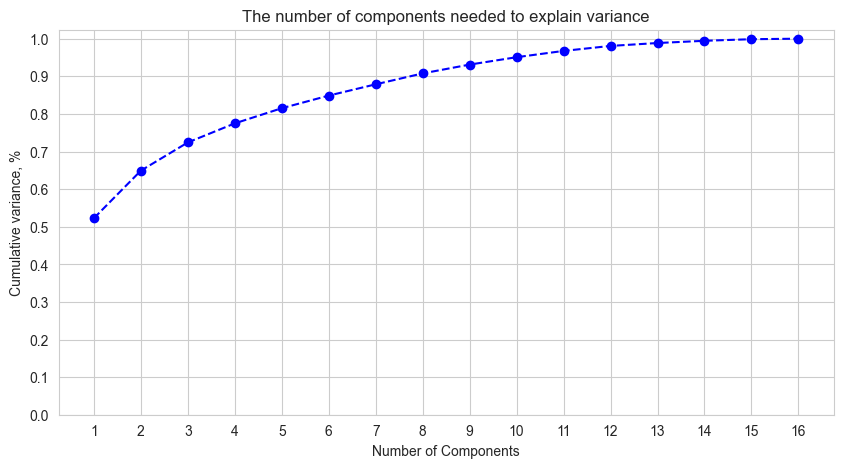

In [191]:
# инициализируем и применим модель PCA
pca = PCA().fit(X)

# построим график куммулятивной дисперсии для каждого количества главных компонент
plt.subplots(figsize=(10, 5))
# по оси х количество главных компонент
xi = np.arange(1, X.shape[1]+1)
# процент дисперсии, объясняемый каждым из выбранных компонентов,
# накапливаемый куммулятивно (т.е. сумма для каждого количества главных компонент)
yi = np.cumsum(pca.explained_variance_ratio_)
# строим график куммулятивной дисперсии для каждого количества главных компонент
plt.plot(xi, yi, marker='o', linestyle='--', color='b')
# задаем названия графика, осей, шаг отметок на осях
plt.xlabel('Number of Components')
plt.xticks(xi)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel('Cumulative variance, %')
plt.title('The number of components needed to explain variance')


Для каждого количества главных компонент на графике указывается значение куммулятивной дисперсии. Мы сами должны выбрать границу минимально возможной дисперсии и соответствющее минимальное количество главных компонент, обеспечивающее эту дисперсию.

Видно, что количество главных компонент = 2 обеспечивает величину куммулятивной дисперсии 65 %, что сопоставимо с результатом факторного анализа FA. 

Определить какие признаки и в каком масштабе вносят вклад в главные компоненты - невозможно.

Выведем процент дисперсии от каждого признака (главной компоненты). А также, какой объем куммулятивной дисперсии обьясняют эти наборы новых признаков (16 вариантов, каждый набор на 1 признак больше).

In [192]:
# задаем количество главных компонент = 16 в модели PCA
pca = PCA(n_components=X.shape[1],
          whiten=True,
          svd_solver='full',
          random_state=42)

pca.fit_transform(X)

# выводим проценты дисперсии для каждого нового признака
# и объемы куммулятивной дисперсии
ratio_pca = pd.DataFrame(
    (pca.explained_variance_ratio_).round(3),
    columns=['% variance'],
    index=features_list
    )

ratio_pca['cumsum_variance'] = ratio_pca['% variance'].cumsum(axis=0).round(2)

ratio_pca


,% variance,cumsum_variance
S1_Temp,0.523,0.52
S2_Temp,0.126,0.65
S3_Temp,0.075,0.72
S4_Temp,0.051,0.78
S1_Light,0.040,0.82
S2_Light,0.034,0.85
S3_Light,0.030,0.88
S4_Light,0.029,0.91
S1_Sound,0.023,0.93
S2_Sound,0.020,0.95


### 3. UMAP

Используем те же данные, что и для факторного анализа и PCA.

UMAP не имеет функции предсказания, поэтому для оценки качества будем использовать классификатор случайного леса (с "лучшими параметрами") и его атрибут score (mean accuracy). Вычислим этот показатель для каждого варианта количества новых факторов (от 1 до 16) и визуализируем эту зависимость.

Text(0.5, 1.0, 'The number of components for RFC mean accuracy')

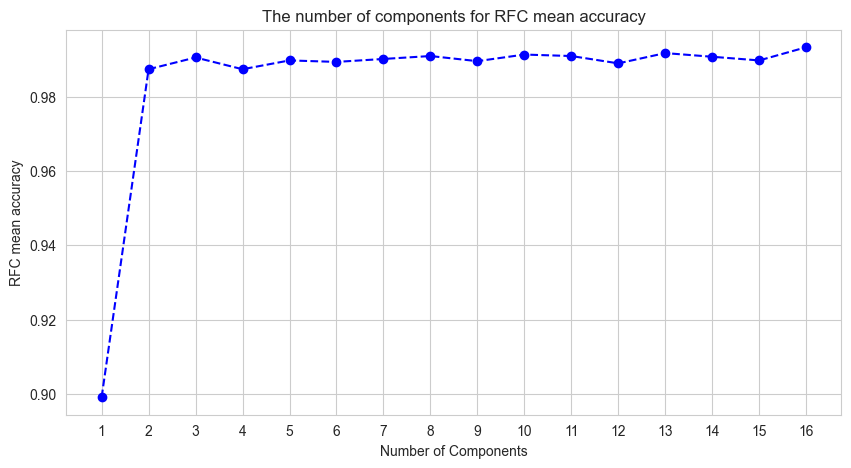

In [193]:
# инициализируем список значений score
num_scores = []

# для каждого количества новых факторов
for num in range(1, X.shape[1]+1):
    # инициализируем и транформируем исходный
    # массив признаков в новые факторы
    reducer = umap.UMAP(n_components=num,
                        n_jobs=-1)
    embedding = reducer.fit_transform(X)

    # разделим новый набор признаков (факторов) и
    # целевую переменную на тренировочную и тестовую выборки
    X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(
        embedding,
        y,
        test_size=0.5,
        shuffle=True,
        stratify=y
        )

    # используем классификатор случайного леса
    # для предсказания на новых признаках
    rf = RandomForestClassifier(**rfc_param).fit(X_train_umap, y_train_umap)
    # вычислим score
    score = rf.score(X_test_umap, y_test_umap)

    # занесем его значений в список значений score
    num_scores.append(score)

# визуализируем получившиеся зависимости
fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(range(1, X.shape[1]+1), num_scores, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(range(1, X.shape[1]+1))
# plt.yticks(range(0.8, 1.1, 0.1))
plt.ylabel('RFC mean accuracy')
plt.title('The number of components for RFC mean accuracy')


Видно, что подмножества признаков более 2 не обеспечивают прироста качества. Это означает, что нужно выбрать 2 фактора.

Преобразование нелинейно, соответственно определить какие признаки и в каком масштабе вносят вклад в главные компоненты - невозможно.

## Уменьшение размерности (отбор признаков)

Отбор признаков является другим вариантом подготовки данных для использования в обучении модели МО. Метод отбора признаков пытается найти подмножество исходных признаков по неким критериям (влияния на целевую переменную, взаимной корреляции и т.д.).

### 1. Оценка взаимной информации

Определим "взаимную информацию", т.е. влияние признаков на дискретную целевую переменную с помощью mutual_info_classif библиотеки sklearn. Взаимная информация между двумя случайными величинами представляет собой неотрицательную величину, которая измеряет зависимость между переменными. Она равна нулю тогда, когда две случайные величины независимы, а более высокие значения означают более высокую зависимость. Этот метод основан на непараметрических методах, основанных на оценке энтропии на основе расстояний k-ближайших соседей. Его можно использовать для одномерного выбора функций.

In [194]:
# вычисляем числовые оценки зависимости целевой переменной от всех признаков
import_feat = mutual_info_classif(X,
                                  y,
                                  n_neighbors=10,
                                  random_state=42)

# представим результат в виде датафрейма
features_mic = pd.DataFrame(
    {'features': features_list, 'importance': import_feat}
)
# представим значения в виде процентных долей и
# добавим куммулятивный столбец для важности
sum_import = features_mic['importance'].sum()
features_mic['importance'] = features_mic['importance'].apply(
    lambda x: x/sum_import*100)
features_mic = features_mic.sort_values(
    'importance', ascending=False).reset_index(drop=True)
features_mic['cumsum_importance'] = features_mic['importance'].cumsum(axis=0)

features_mic


,features,importance,cumsum_importance
0,S1_Light,10.669049,10.669049
1,S2_Light,9.686111,20.355160
2,S3_Light,7.893661,28.248821
3,S5_CO2_Slope,7.332471,35.581291
4,S2_Temp,7.061053,42.642344
5,S4_Light,6.875261,49.517606
6,S1_Sound,6.378618,55.896224
7,S2_Sound,6.362517,62.258741
8,S3_Sound,6.103766,68.362508
9,S5_CO2,6.022930,74.385437


Таким образом, используя функцию mutual_info_classif мы ранжировали признаки по степени их парной зависимости с целевой переменной. Теперь можно выбирать сочетания наиболее влияющих на результат признаков для предсказаний моделями МО.

Например, для получения объема взаимной информации (с целевой переменной) в 43 % необходимо испозовать 5 первых признаков из выше приведенной таблицы.

### 2. Выбор подмножества функций

Выбор подмножества из всего множества признаков. Это оценка важности для признаков (влияние на целевую переменную) с помощью SequentialFeatureSelector библиотеки mlxtend. Используется модель логистической регрессии с параметрами по умолчанию.

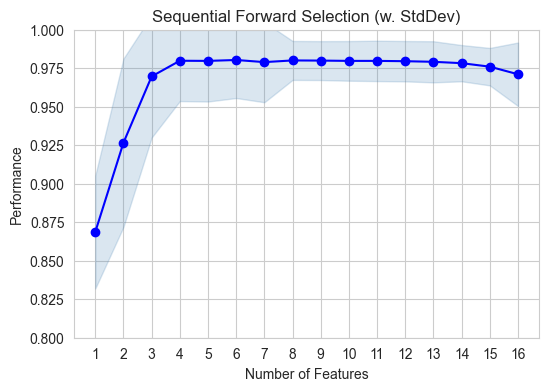

In [195]:
# в качестве классификатора будем использовать
# модель логистической регрессии с параметрами по умолчанию
lr = LogisticRegression(random_state=42, n_jobs=-1)

# инициализируем и обучим модель
# последовательного выбора функций для классификации,
# указав весь набор признаков
sfs = SFS(lr,
          k_features=X.shape[1],
          forward=True,
          floating=True,
          scoring='accuracy',
          cv=5,
          n_jobs=-1)

sfs = sfs.fit(X, y)

# построим график значения выбранной оценки от
# конкретного подмножества признаков
# (перебираются все варианты количества признаков от 1
# до максимального, для каждого варианта выбираются те признаки,
# которые дают максимальное значение оценки)
fig1 = plot_sfs(sfs.get_metric_dict(),
                kind='std_dev',
                figsize=(6, 4))

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid(True)


Видно, что подмножества признаков более 4 не обеспечивают существенного прироста качества. 

Определим, какие-именно 5 признаков следует использовать для такого подмножества (для всех вариантов отбора признаков используем 5 факторов).

In [196]:
# атрибут subsets_ это словарь выбранных подмножеств объектов
# во время последовательного выбора, число (ключ) указывает на количество
# элементов подмножества, а ключ feature_idx - кортеж индексов подмножества функций

features_sfs = [features_list[feat] for feat in sfs.subsets_[5]['feature_idx']]

features_sfs


['S1_Light', 'S2_Light', 'S3_Light', 'S3_Sound', 'S7_PIR']

### 3. Выбор признаков с помощью модели МО

Используем модель классификатора случайного леса для получения значимости использованных при построении модели признаков на основе примесей, в виде процентных долей.

In [197]:
# инициализируем и обучим модель
# с подобранными ранее гиперпараметрами
rf_best = RandomForestClassifier(**rfc_param)
rf_best.fit(X_train, y_train)

# получим массив значений важности признаков
# и представим в виде датафрейма
features_rfc = pd.DataFrame(
    data=[feature for feature in zip(features_list,
                                     rf_best.feature_importances_)],
    columns=['features', 'importance']
)
# отсортируем по убыванию
features_rfc = features_rfc.sort_values(by='importance', ascending=False)
features_rfc = features_rfc.reset_index(drop=True)
# приведем значения к процентам вместо долей
features_rfc['importance'] = features_rfc['importance']*100
# добавим столбец куммулятивной суммы
features_rfc['cumsum_importance'] = features_rfc['importance'].cumsum(axis=0)

features_rfc


,features,importance,cumsum_importance
0,S1_Light,23.275962,23.275962
1,S2_Light,12.820804,36.096766
2,S5_CO2_Slope,12.285201,48.381967
3,S1_Sound,10.745338,59.127305
4,S3_Light,8.791637,67.918943
5,S2_Sound,5.443170,73.362112
6,S3_Sound,5.307433,78.669545
7,S5_CO2,4.466091,83.135636
8,S2_Temp,3.644386,86.780021
9,S1_Temp,3.378993,90.159014


Таким образом, используя возможности классификатора случайного леса мы ранжировали используемые признаки для получения их значимости при построении модели признаков на основе примесей. Теперь можно выбирать сочетания наиболее влияющих на результат признаков для предсказаний моделями МО.

Например, для получения объема взаимной информации (с целевой переменной) в 68 % необходимо испозовать 5 первых признака из выше приведенной таблицы.

# **Построение модели (уменьшенный набор признаков)**

Попробуем все шесть вариантов уменьшения размерности и к новым наборам признаков применим алгоритм классификатора случайного леса с ранее определенными "лучшими" параматрами.

Для проекций признаков будем уменьшать размерность до 2 новых факторов (признаков). Для отбора - будем выбирать 5 из существующих признаков. Кроме того, попоробуем уменьшить размерность до 1 признака. 

Обучать модели уменьшения размерности (проекция признаков) будем на тренировочной выборке и применять к тренировочной и тестовой, чтобы застраховаться от возможной утечки в случае обучения на всей выборке.

Для всех вариантов используем алгоритм классификатора случайного леса с ранее определенными "лучшими" параматрами. Дополнительно для вариантов с 2 и 1 новыми факторами (признаками) используем логистическую регрессию и LightGBM (для сравнения).

### 1. FA (факторный анализ) (2 признака)

In [198]:
# уменьшим набор признаков до 2
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(X_train)
X_train_fa_2 = fa.transform(X_train)
X_test_fa_2 = fa.transform(X_test)

# используем классификатор случайного леса
# для предсказания на новых признаках
rf = RandomForestClassifier(**rfc_param)
rf.fit(X_train_fa_2, y_train)
y_pred_fa_2 = rf.predict(X_test_fa_2)

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('RandomForestClassifier (FA, 2 features)',
                          y_test,
                          y_pred_fa_2)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4114
           1       0.88      0.89      0.88       230
           2       0.89      0.93      0.91       374
           3       0.88      0.83      0.86       347

    accuracy                           0.98      5065
   macro avg       0.91      0.91      0.91      5065
weighted avg       0.98      0.98      0.98      5065



Text(45.722222222222214, 0.5, 'Actual/Observed')

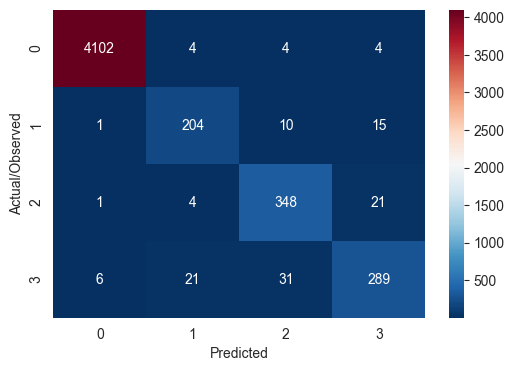

In [199]:
# построим матрицу ошибок и визуализируем ее
cm = confusion_matrix(y_test, y_pred_fa_2)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


### 2. PCA (метод главных компонент) (2 признака)

In [200]:
# уменьшим набор признаков до 2
pca = PCA(n_components=2,
          whiten=True,
          svd_solver='full',
          random_state=42)
pca.fit(X_train)
X_train_pca_2 = pca.transform(X_train)
X_test_pca_2 = pca.transform(X_test)

# используем классификатор случайного леса
# для предсказания на новых признаках
rf = RandomForestClassifier(**rfc_param)
rf.fit(X_train_pca_2, y_train)
y_pred_pca_2 = rf.predict(X_test_pca_2)

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('RandomForestClassifier (PCA, 2 features)',
                          y_test,
                          y_pred_pca_2)


              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4114
           1       0.80      0.85      0.82       230
           2       0.82      0.85      0.83       374
           3       0.81      0.78      0.80       347

    accuracy                           0.96      5065
   macro avg       0.86      0.87      0.86      5065
weighted avg       0.96      0.96      0.96      5065



Text(45.722222222222214, 0.5, 'Actual/Observed')

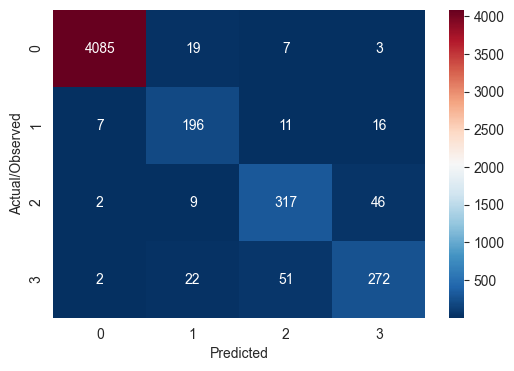

In [201]:
# построим матрицу ошибок и визуализируем ее
cm = confusion_matrix(y_test, y_pred_pca_2)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


### 3. UMAP (приближение и проекция равномерного многообразия) (2 признака)

In [202]:
# уменьшим набор признаков до 2
reducer = umap.UMAP(n_components=2,
                    n_jobs=-1,
                    random_state=42)
reducer.fit(X_train)
X_train_umap_2 = reducer.transform(X_train)
X_test_umap_2 = reducer.transform(X_test)

# используем классификатор случайного леса
# для предсказания на новых признаках
rf = RandomForestClassifier(**rfc_param)
rf.fit(X_train_umap_2, y_train)
y_pred_umap_2 = rf.predict(X_test_umap_2)

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('RandomForestClassifier (UMAP, 2 features)',
                          y_test, y_pred_umap_2)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4114
           1       0.95      0.98      0.97       230
           2       0.92      0.89      0.91       374
           3       0.90      0.91      0.90       347

    accuracy                           0.98      5065
   macro avg       0.94      0.95      0.94      5065
weighted avg       0.98      0.98      0.98      5065



Text(45.722222222222214, 0.5, 'Actual/Observed')

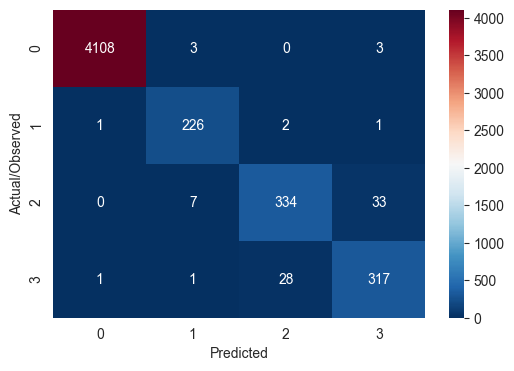

In [203]:
# построим матрицу ошибок и визуализируем ее
cm = confusion_matrix(y_test, y_pred_umap_2)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


### 4. Оценка взаимной информации (MIC)

In [204]:
# получим список номеров выбранных признаков
need_col_mic = [features_list.index(
    col) for col in features_mic['features'][:5].to_list()]

# используем классификатор случайного леса
# для предсказания на новых признаках
rf = RandomForestClassifier(**rfc_param)
rf.fit(X_train[:, need_col_mic], y_train)
y_pred_mic = rf.predict(X_test[:, need_col_mic])

# выведем признаки, которые используются для построения модели
print(f'Features number: {need_col_mic}')

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('RandomForestClassifier (MIC, 5 features)',
                          y_test,
                          y_pred_mic)


Features number: [4, 5, 6, 13, 1]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4114
           1       0.99      1.00      1.00       230
           2       0.99      0.98      0.98       374
           3       0.98      0.99      0.98       347

    accuracy                           1.00      5065
   macro avg       0.99      0.99      0.99      5065
weighted avg       1.00      1.00      1.00      5065



Text(45.722222222222214, 0.5, 'Actual/Observed')

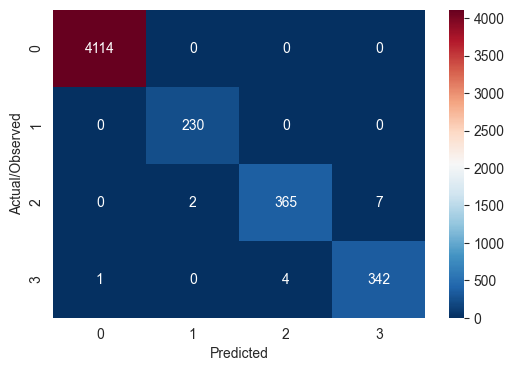

In [205]:
# построим матрицу ошибок и визуализируем ее
cm = confusion_matrix(y_test, y_pred_mic)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


### 5. Выбор подмножества функций (SFS)

In [206]:
# получим список номеров выбранных признаков
need_col_sfs = [features_list.index(col) for col in features_sfs]

# используем классификатор случайного леса
# для предсказания на новых признаках
rf = RandomForestClassifier(**rfc_param)
rf.fit(X_train[:, need_col_sfs], y_train)
y_pred_sfs = rf.predict(X_test[:, need_col_sfs])

# выведем признаки, которые используются для построения модели
print(f'Features number: {need_col_sfs}')

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('RandomForestClassifier (SFS, 5 features)',
                          y_test,
                          y_pred_sfs)


Features number: [4, 5, 6, 10, 15]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4114
           1       0.99      1.00      0.99       230
           2       0.98      0.97      0.97       374
           3       0.95      0.96      0.96       347

    accuracy                           0.99      5065
   macro avg       0.98      0.98      0.98      5065
weighted avg       0.99      0.99      0.99      5065



Text(45.722222222222214, 0.5, 'Actual/Observed')

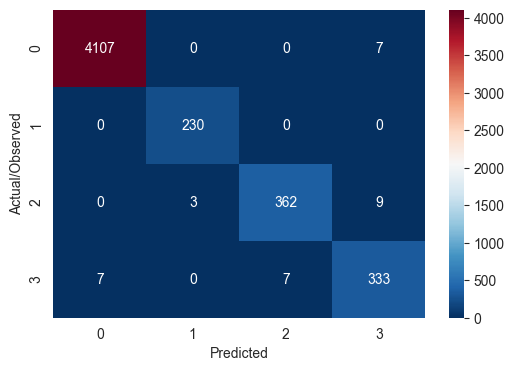

In [207]:
# построим матрицу ошибок и визуализируем ее
cm = confusion_matrix(y_test, y_pred_sfs)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


### 6. Выбор признаков с помощью модели МО (RFC)

In [208]:
# получим список номеров выбранных признаков
need_col_rfc = [features_list.index(
    col) for col in features_rfc['features'][:5].to_list()]

# используем классификатор случайного леса
# для предсказания на новых признаках
rf = RandomForestClassifier(**rfc_param)
rf.fit(X_train[:, need_col_rfc], y_train)
y_pred_rfc = rf.predict(X_test[:, need_col_rfc])

# выведем признаки, которые используются для построения модели
print(f'Features number: {need_col_rfc}')

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('RandomForestClassifier (RFC, 5 features)',
                          y_test,
                          y_pred_rfc)


Features number: [4, 5, 13, 8, 6]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4114
           1       0.99      1.00      0.99       230
           2       0.98      0.97      0.98       374
           3       0.98      0.98      0.98       347

    accuracy                           1.00      5065
   macro avg       0.99      0.99      0.99      5065
weighted avg       1.00      1.00      1.00      5065



Text(45.722222222222214, 0.5, 'Actual/Observed')

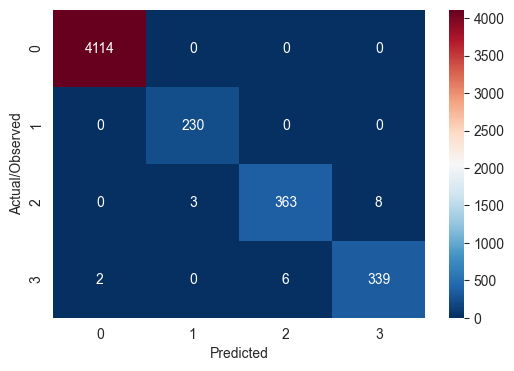

In [209]:
# построим матрицу ошибок и визуализируем ее
cm = confusion_matrix(y_test, y_pred_rfc)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


### 7. FA (1 признак)

In [210]:
# уменьшим набор признаков до 1
fa = FactorAnalyzer(n_factors=1, rotation='varimax')
fa.fit(X_train)
X_train_fa_1 = fa.transform(X_train)
X_test_fa_1 = fa.transform(X_test)

# используем классификатор случайного леса
# для предсказания на новых признаках
rf = RandomForestClassifier(**rfc_param)
rf.fit(X_train_fa_1, y_train)
y_pred_fa_1 = rf.predict(X_test_fa_1)

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('RandomForestClassifier (FA, 1 feature)',
                          y_test,
                          y_pred_fa_1)


              precision    recall  f1-score   support

           0       0.98      0.97      0.97      4114
           1       0.45      0.49      0.47       230
           2       0.69      0.71      0.70       374
           3       0.54      0.53      0.54       347

    accuracy                           0.90      5065
   macro avg       0.67      0.68      0.67      5065
weighted avg       0.90      0.90      0.90      5065



Text(45.722222222222214, 0.5, 'Actual/Observed')

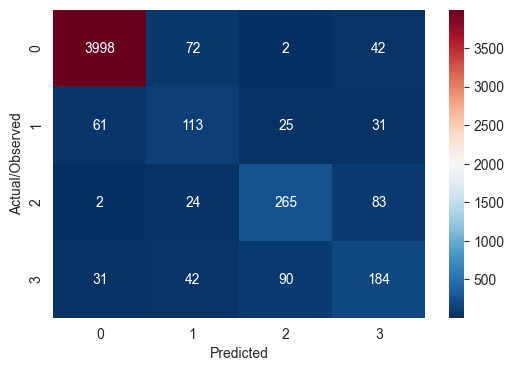

In [211]:
# построим матрицу ошибок и визуализируем ее
cm = confusion_matrix(y_test, y_pred_fa_1)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


### 8. PCA (1 признак)

In [212]:
# уменьшим набор признаков до 1
pca = PCA(n_components=1,
          whiten=True,
          svd_solver='full',
          random_state=42)
pca.fit(X_train)
X_train_pca_1 = pca.transform(X_train)
X_test_pca_1 = pca.transform(X_test)

# используем классификатор случайного леса
# для предсказания на новых признаках
rf = RandomForestClassifier(**rfc_param)
rf.fit(X_train_pca_1, y_train)
y_pred_pca_1 = rf.predict(X_test_pca_1)

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('RandomForestClassifier (PCA, 1 feature)',
                          y_test,
                          y_pred_pca_1)


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4114
           1       0.42      0.45      0.43       230
           2       0.60      0.61      0.61       374
           3       0.49      0.48      0.48       347

    accuracy                           0.88      5065
   macro avg       0.62      0.63      0.62      5065
weighted avg       0.89      0.88      0.89      5065



Text(45.722222222222214, 0.5, 'Actual/Observed')

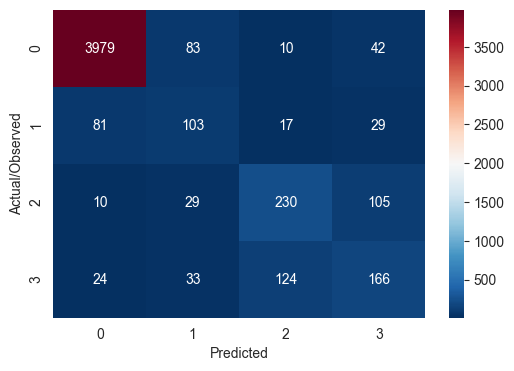

In [213]:
# построим матрицу ошибок и визуализируем ее
cm = confusion_matrix(y_test, y_pred_pca_1)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


### 9. UMAP (1 признак)

In [214]:
# уменьшим набор признаков до 1
reducer = umap.UMAP(n_components=1,
                    n_jobs=-1,
                    random_state=42)
reducer.fit(X_train)
X_train_umap_1 = reducer.transform(X_train)
X_test_umap_1 = reducer.transform(X_test)

# используем классификатор случайного леса
# для предсказания на новых признаках
rf = RandomForestClassifier(**rfc_param)
rf.fit(X_train_umap_1, y_train)
y_pred_umap_1 = rf.predict(X_test_umap_1)

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('RandomForestClassifier (UMAP, 1 feature)',
                          y_test,
                          y_pred_umap_1)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4114
           1       0.90      0.97      0.94       230
           2       0.81      0.81      0.81       374
           3       0.82      0.78      0.80       347

    accuracy                           0.97      5065
   macro avg       0.88      0.89      0.89      5065
weighted avg       0.97      0.97      0.97      5065



Text(45.722222222222214, 0.5, 'Actual/Observed')

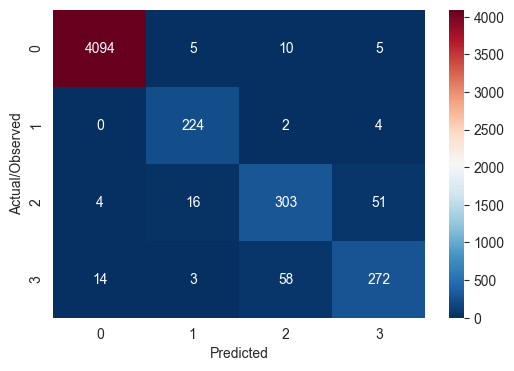

In [215]:
# построим матрицу ошибок и визуализируем ее
cm = confusion_matrix(y_test, y_pred_umap_1)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


## Дополнительно 
LightGBM и линейная регрессия для 1 и 2 признаков.

Проверим качество алгоритмов LigtGBM и линейной регрессии (как baseline) при использовании 2 и 1 новых признаков (метод уменьшения размерности пространства признаков). В качестве метода применим UMAP, т.к. он показал лучшие результаты для уменьшения размерности и до 2 и до 1 признака, причем с существенным отрывом.

### 10. LightGBM (2 признака)

In [216]:
# используем LightGBM для предсказания на 2 признаках
model = lgb.LGBMClassifier(**lgbm_param, num_boost_round=1000)
model.fit(X_train_umap_2, y_train)
y_pred_lgbm_2 = model.predict(X_test_umap_2)

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('LGBM (UMAP, 2 features)',
                          y_test,
                          y_pred_lgbm_2)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4114
           1       0.95      0.97      0.96       230
           2       0.90      0.88      0.89       374
           3       0.89      0.89      0.89       347

    accuracy                           0.98      5065
   macro avg       0.93      0.94      0.93      5065
weighted avg       0.98      0.98      0.98      5065



Text(45.722222222222214, 0.5, 'Actual/Observed')

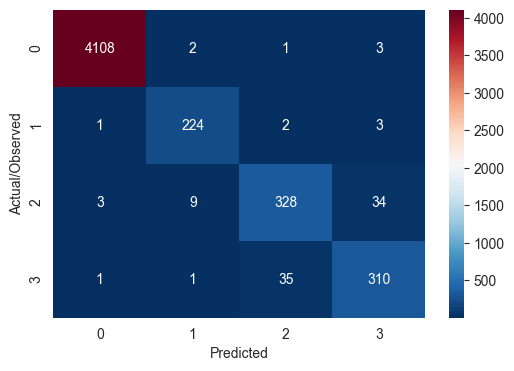

In [217]:
# построим матрицу ошибок и визуализируем ее
cm = confusion_matrix(y_test, y_pred_lgbm_2)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


### 11. LightGBM (1 признак)

In [218]:
# используем LightGBM для предсказания на 1 признаке
model = lgb.LGBMClassifier(**lgbm_param, num_boost_round=1000)
model.fit(X_train_umap_1, y_train)
y_pred_lgbm_1 = model.predict(X_test_umap_1)

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('LGBM (UMAP, 1 feature)',
                          y_test,
                          y_pred_lgbm_1)


              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4114
           1       0.89      0.98      0.93       230
           2       0.87      0.83      0.85       374
           3       0.80      0.91      0.85       347

    accuracy                           0.97      5065
   macro avg       0.89      0.93      0.91      5065
weighted avg       0.97      0.97      0.97      5065



Text(45.722222222222214, 0.5, 'Actual/Observed')

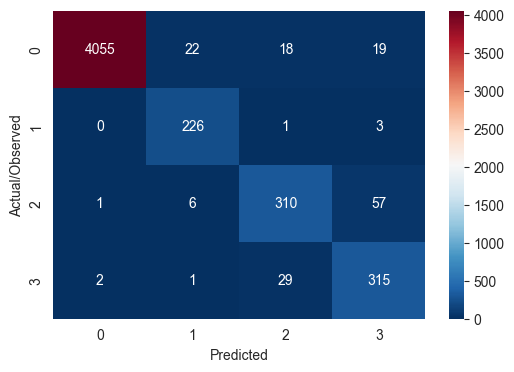

In [219]:
# построим матрицу ошибок и визуализируем ее
cm = confusion_matrix(y_test, y_pred_lgbm_1)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


### 12. Логистическая регрессия (2 признака)

In [220]:
# используем модель логистической регрессии
# для предсказания на 1 признаке
lr = LogisticRegression(**lr_param)
lr.fit(X_train_umap_2, y_train)
y_pred_lr_2 = lr.predict(X_test_umap_2)

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('LogisticRegression plus (UMAP, 2 features)',
                          y_test,
                          y_pred_lr_2)


              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4114
           1       0.38      0.70      0.49       230
           2       0.42      0.55      0.47       374
           3       0.77      0.47      0.58       347

    accuracy                           0.88      5065
   macro avg       0.64      0.67      0.63      5065
weighted avg       0.91      0.88      0.89      5065



Text(45.722222222222214, 0.5, 'Actual/Observed')

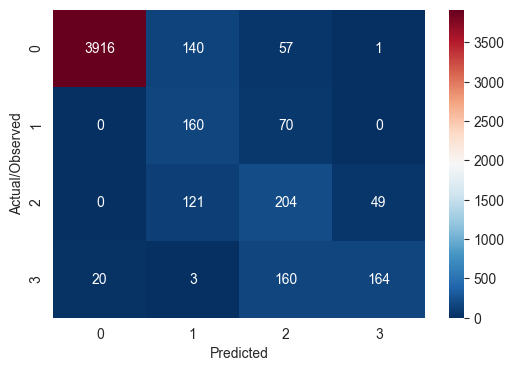

In [221]:
# построим матрицу ошибок и визуализируем ее
cm = confusion_matrix(y_test, y_pred_lr_2)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


### 13. Логистическая регрессия (1 признак)

In [222]:
# используем модель логистической регрессии
# для предсказания на 1 признаке
lr = LogisticRegression(**lr_param)
lr.fit(X_train_umap_1, y_train)
y_pred_lr_1 = lr.predict(X_test_umap_1)

# вычислим значения метрик, запишем их в таблицу и выведем
df_result = metrics_score('LogisticRegression plus (UMAP, 1 feature)',
                          y_test,
                          y_pred_lr_1)


              precision    recall  f1-score   support

           0       1.00      0.80      0.89      4114
           1       0.22      0.69      0.33       230
           2       0.27      0.48      0.35       374
           3       0.18      0.20      0.19       347

    accuracy                           0.73      5065
   macro avg       0.42      0.54      0.44      5065
weighted avg       0.85      0.73      0.77      5065



Text(45.722222222222214, 0.5, 'Actual/Observed')

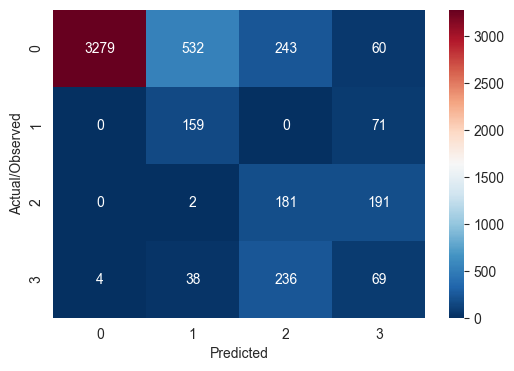

In [223]:
# построим матрицу ошибок и визуализируем ее
cm = confusion_matrix(y_test, y_pred_lr_1)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


In [224]:
# время конца записи
end = time.time()

# print the difference between start
# and end time in milli. secs
print(
    f'The time of execution of above program is : {int((end-start)//60)} min {round((end-start)%60)} s')


The time of execution of above program is : 6 min 48 s


## Выводы

In [225]:
# итоговая таблица
df_result


,Model,Accuracy,Precision,Recall,F1 Score,f1_0,f1_1,f1_2,f1_3,error,% error %
0,LogisticRegression (full features),0.99289,0.99302,0.99289,0.99294,0.998296,0.997831,0.970667,0.950213,36,0.710760
1,LogisticRegression plus (full features),0.99506,0.99510,0.99506,0.99508,0.999149,1.000000,0.976000,0.964132,25,0.493583
2,RandomForestClassifier (full features),0.99763,0.99763,0.99763,0.99763,0.999878,0.995671,0.985274,0.985549,12,0.236920
3,LGBM (full features),0.99684,0.99684,0.99684,0.99683,0.999757,0.991379,0.981132,0.982709,16,0.315893
4,"RandomForestClassifier (full featuers, undupli...",0.99683,0.99683,0.99683,0.99683,0.999711,0.989107,0.983871,0.987088,14,0.317173
5,"LogisticRegression plus (full featuers, undupl...",0.99388,0.99394,0.99388,0.99390,0.998700,0.991266,0.974428,0.968661,27,0.611690
6,"LGBM (full featuers, unduplicated)",0.99705,0.99706,0.99705,0.99705,0.999711,0.989107,0.985235,0.988506,13,0.294517
7,RandomForestClassifier (14 featuers),0.99763,0.99763,0.99763,0.99763,0.999878,0.995671,0.985274,0.985549,12,0.236920
8,LogisticRegression plus (14 features),0.99506,0.99508,0.99506,0.99507,0.999392,0.997831,0.973333,0.965418,25,0.493583
9,LGBM (14 features),0.99684,0.99685,0.99684,0.99683,0.999878,0.989247,0.979757,0.984173,16,0.315893


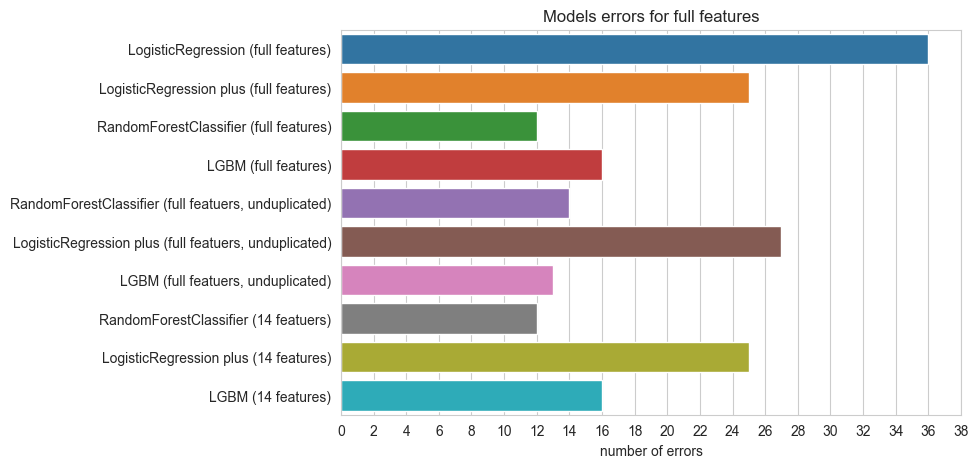

In [226]:
# ошибки моделей с полным набором признаков +
# варианты с удаленными дубликатами и признаками движения
fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(
    x=df_result.loc[:9, 'error'],
    y=df_result.loc[:9, 'Model']
    )

ax.set_title('Models errors for full features')
plt.xlabel('number of errors')
plt.ylabel('')
ax.set_xticks(range(0, 40, 2))


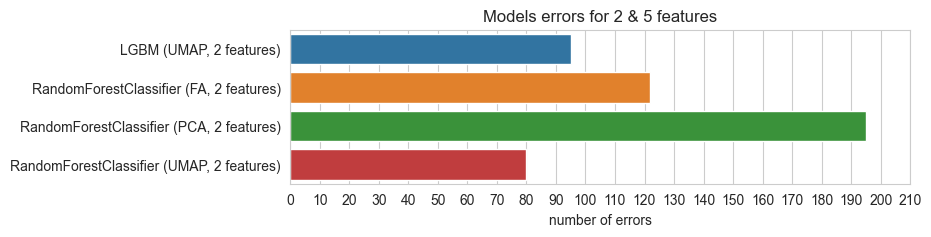

In [227]:
# ошибки моделей с 2 признаками (уменьшение размерности)
df_2 = pd.concat([df_result.iloc[19:20], df_result.iloc[10:13]])

fig, ax = plt.subplots(figsize=(8, 2))
sns.barplot(
    x=df_2['error'],
    y=df_2['Model']
    )

plt.title('Models errors for 2 & 5 features')
plt.xlabel('number of errors')
plt.ylabel('')
ax.set_xticks(range(0, 220, 10))


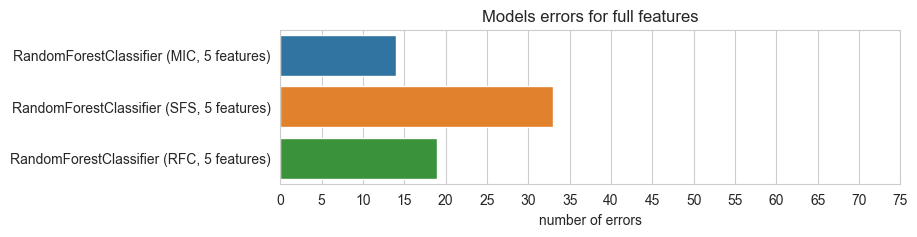

In [228]:
# ошибки модели логистической регрессии
# с 5 признаками  (уменьшение размерности)
fig, ax = plt.subplots(figsize=(8, 2))

sns.barplot(
    x=df_result.loc[13:15, 'error'],
    y=df_result.loc[13:15, 'Model']
    )

ax.set_title('Models errors for full features')
plt.xlabel('number of errors')
plt.ylabel('')
ax.set_xticks(range(0, 80, 5))


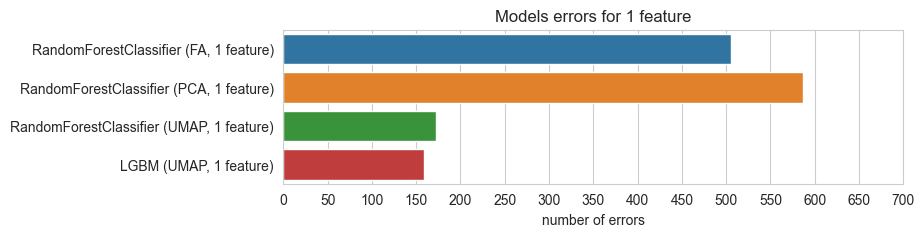

In [229]:
# ошибки моделей с 1 признаком движения (уменьшение размерности)
df_3 = pd.concat([df_result.iloc[16:19], df_result.iloc[20:21]])

fig, ax = plt.subplots(figsize=(8, 2))
sns.barplot(
    x=df_3['error'],
    y=df_3['Model']
    )

plt.title('Models errors for 1 feature')
plt.xlabel('number of errors')
plt.ylabel('')
ax.set_xticks(range(0, 750, 50))


Всего использовано 3 модели: 
- логистическая регрессия (как baseline),
- классификатор случайного леса,
- LigtGBM.

Для всех моделей подбирались гиперпараметры (с помощью GridSearchCV и Optuna, для LightGBM) при использовании всего набора признаков. И эти модели использовались с постоянными гиперпараметрами.

Модели применялись к полным и уменьшенным наборам факторов (16 признаков). Для полных наборов дополнительно проверялись варианты с удаленными дубликатами и удаленными признаками движения. 

**Полные наборы признаков:**
Уменьшенные наборы имели три варианта количества признаков:
* все признаки.
* все признаки с удаленными дубликатами (примерно 13 % признаков).
* 14 признаков (удалены 2 признака обнаружения движения).

После обучения на полных наборах в качестве лучшей была выбрана модель классификатора случайного леса. В целом, при использовании полного набора признаков даже логистическая регрессия дает приемлемый результат, особенно с подбором гиперпараметров. Результат классификатора случайного леса: 0.99763 для метрики f1 (weighted) и 12 ошибок классификации для 5 тыс. значений тестовой выборки. Ожидаемо для класса 0 (по сути это определение наличия/отсутствия людей в помещении, т.е. бинарная задача - или есть люди или нет) всего 1 ошибка. Т.е. практически все ошибки модель допустила в определении точного количества людей при их наличии вообще. Что логично, т.к. исходя из природы предоставленных данных это сделать сложнее. LightGBM не много отстал - 16 ошибок. У логистической регрессии уже 25 ошибок (для сравнения у логистической регрессии с параметрами по умолчанию 36 ошибок). В оценках метрики f1 (weighted) разница - десятые доли процента. Аналогично определение 0 класса немного лучше, чем остальных трех.

При удалении дубликатов результат хуже: для классификатора случайного леса и логистической регрессии количество ошибок увеличилось на 2 (т.е. логистическая регрессия ошибается в два раза меньше, в процентном отношении). Для LightGBM количество ошибок наоборот уменьшилось на 3, однако здесь необходимо учитывать влияние стохастичности алгоритма, невозможность точного воспроизведения результатов.  

При удалении 2 признаков движения - результат полностью аналогичен результату с полным набором. Для LightGBM - аналогично полному набору признаков. Опять нужно отметить стохастический характер алгоритма и способ подбора гиперпараметров (также несколько "неоднозначный").

В целом использование полного набора дает 0.2 - 0.3 % ошибок от тестовой выборки для алгоритмов: классификатор случайного леса и LightGBM.

**Уменьшенные наборы признаков:**

Уменьшенные наборы имели три варианта количества "новых" признаков:
* 2 признака, полученные 3 способами уменьшения размерности - проекциями признаков: FA, PCA и UMAP, причем UMAP интересен тем, что это нелинейное преобразование, в отличие от двух других. Это "рабочее" преобразование для feature engineering решаемой задачи, т.к. данный вариант предполагает использование для создания модели МО минимального количества признаков = 2.
* 5 признаков, полученные 3 способами уменьшения размерности - отборами признаков: оценка взаимной информации mutual_info_classif библиотеки sklearn, выбор подмножества функций SequentialFeatureSelector библиотеки mlxtend, выбор признаков с помощью модели МО используется (классификатор случайного леса). Этот вариант был рассмотрен с целью сравнения со способами уменьшения размерности - проекциями признаков.
* 1 признак, полученный аналогично наборам из 2 параметров, с помощью проекции признаков теми же способами. Этот вариант был рассмотрен с целью изучения качества моделей при самом "экстремальном" преобразовании пространства признаков.

Для двух признаков лучшим способом уменьшения размерности оказался UMAP: классификатор случайного леса показал 80 ошибок против 122 и 195 для FA и PCA, соответственно. Это очень большой отрыв. LigtGBM с UMAP показал 95 ошибок, что хуже, чем классификатор случайного леса. А логистическая регрессия провалилась: 621 ошибки - 12 % от всех значений тестовых данных. Следует отметить, что использование уменьшения размерности с помощью UMAP может дать результат лучше, чем отбор 5 признаков - т.е. 2 сконструированных нелинейным образом признака предпочтительнее, чем 5 отобранных самых лучших оригинальных (для классификатора случайного леса). Может дать - потому, что и UMAP и FA стохастические алгоритмы. Для UMAP можно зафиксировать random state, однако точного повторения все равно не будет. FA,  в-принципе, лишен такой возможности. В целом использование уменьшения размерности до 2 признаков дает от 1.5 до 2 % ошибок от тестовой выборки для классификатора случайного леса и LightGBM.

Если говорить об отборе имеющихся признаков, то используемые алгоритмы и способы дают результат в 14 и 33 ошибки, а классификатор случайного леса 19 ошибок (после обучения этой модели МО возможно получить данные о значимости признаков на основе примесей и исходя из этого выбрать лучшие, для конкретного их количества). При количестве 5 выбранных признаков, указанные способы отбора признаков обеспечили точности, практически равную использованию всех признаков (или без признаков обнаружения движения): до 0.65 % ошибок от количества значений тестовой выборки. Соотношение количества ошибок по классам выравнивается  (зависит от метода).

Рассматривая "экстремальный вариант": уменьшение размерности пространства признаков до 1, выяснилось, что лучшим является UMAP: 172 ошибки против 505 для FA и 587 для PCA, речь идет о модели классификатора случайного леса. Что является огромной разницей. LightGBM показал 159 ошибок при использовании UMAP для уменьшения размерности, что несколько лучше классификатора случайного леса. Т.о. речь идет о разнице в 3-3.5 %. Логистическая регрессия с такими преобразованиями работает плохо: 1377 ошибок с использованием UMAP или 27 % от всего объема тестовой выборки. Обязательно необходимо учесть, что из-за стохастичности UMAP результаты могуит очень сильно изменяться. Требуется подбор варианта уменьшения размерности с помощью UMAP при котором достигается лучший результат работы модели МО и его использования для обучения этой модели.

**Итоги:**
- лучший алгоритм из рассмотренных - классификатор случайного леса (в зависимости от преобразований пространства признаков, это может быть LightGBM). Следует отметить воспроизводимость, а также встроенный инструмент отбора признаков.
- градиентный бустинг на примере LightGBM показал результаты хуже (с учетом замечания ранее). Имеет стохастичекий характер, что неудобно. Сложный подбор параметров (большое их количество, длительное время подбора или неоднозначные результаты).
- логистическая регрессия, может быть использована только с полным набором исходных данных (уступая другим алгоритмам).
- метод уменьшения размерности путем проекции признаков UMAP показал лучшие результаты при снижении размерности вплоть до 1 нового фактора. Следует отметить минус: имеет стохастический характер, что требует подбора конкретного варианта преобразования для обучения выбранной модели МО.
- рассмотренные методы уменьшения размерности путем отбора признаков по качеству сопоставимы с рассмотренными методами уменьшения размерности путем проекции признаков (при использовании классификатора случайного леса).

**Все указанные выводы справедливы конкретно для этой задачи и этих данных.**


# **Выбор модели**
Для продакшена выбирается модель МО - классификатор случайного леса. 

В данной конкретной задаче уменьшение размерности не требуется, т.к. количество признаков = 16 - невелико, модель не сложная (глубина 20, количество деревьев 1000), стандартизация данных этому алгоритму не требуется.

При большом количестве признаков можно использовать LightGBM и уменьшение размерности UMAP (зависит от коллинеарности признаков).

Подготовка данных для передачи в модель: удаление неинформативных признаков даты и времени. 

Поcтроим выбранную модель еще раз и проверим, выведя текстовый отчет classification_report.

In [230]:
rf_last = RandomForestClassifier(**rfc_param)
rf_last.fit(X_train, y_train)

y_pred_ts = rf_last.predict(X_test)

print(classification_report(y_test, y_pred_ts))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4114
           1       0.99      1.00      1.00       230
           2       0.99      0.98      0.99       374
           3       0.99      0.98      0.99       347

    accuracy                           1.00      5065
   macro avg       0.99      0.99      0.99      5065
weighted avg       1.00      1.00      1.00      5065



Text(45.722222222222214, 0.5, 'Actual/Observed')

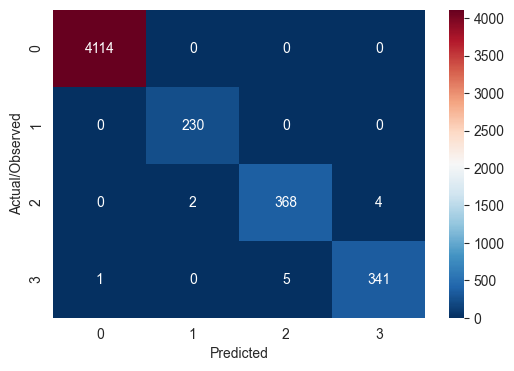

In [231]:
# построим матрицу ошибок и визуализируем ее
cm = confusion_matrix(y_test, y_pred_ts)
plt.figure(figsize=(6, 4))

sns.heatmap(cm,
            annot=True,
            cmap='RdBu_r',
            fmt='g'
            )
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual/Observed', fontsize=10)


Прверим, что модель не переобучена. 

Используем метод cross_validate из библиотеки sklearn. 

Параметры разделения для перекрестной проверки: количество итераций перемешивания и разделения: 40, размер тестовой выборки: 0.5.

Метрики для проверки:
* f1_weighted - f1 взвешенное, 
* f1_macro - f1 среднее для всех классов (не взвешенное),
* balanced_accuracy - сбалансированная (взвешенная accuracy).

In [235]:
# параметры разделения для перекрестной проверки
cv = ShuffleSplit(n_splits=40, test_size=0.5, random_state=42)
# оценим выбранные метрики перекрестной проверкой,
# модель - классификатор случайного леса
# с ранее подобранными гиперпараметрами, полная выборка,
# вывод значений метрик для тренировочной выборки
cv_results = cross_validate(
    rf_last, X, y, cv=cv,
    scoring=('f1_weighted', 'f1_macro', 'balanced_accuracy'),
    return_train_score=True, n_jobs=-1)
# выведем в виде датафрейма
cv_results = pd.DataFrame(cv_results)
cv_results.head(5)


,fit_time,score_time,test_f1_weighted,train_f1_weighted,test_f1_macro,train_f1_macro,test_balanced_accuracy,train_balanced_accuracy
0,2.784418,0.975796,0.997038,1.0,0.989571,1.0,0.989631,1.0
1,2.733945,0.674489,0.997037,1.0,0.989237,1.0,0.988698,1.0
2,3.694803,0.935291,0.997042,1.0,0.989500,1.0,0.989603,1.0
3,2.712901,0.668958,0.997628,1.0,0.991992,1.0,0.991223,1.0
4,4.532380,0.741999,0.996444,1.0,0.987808,1.0,0.987705,1.0


In [234]:
# выведем средние результаты значений метрик для тестовой выборки
cv_results[['test_f1_weighted', 'test_f1_macro', 'test_balanced_accuracy']].mean()


test_f1_weighted          0.996886
test_f1_macro             0.989135
test_balanced_accuracy    0.988912
dtype: float64

Видно, что значения метрик для всех 40 итераций для тренировочных выборок равны 1. Средние значения метрик для тестовых выборок не менее 0.99. 

Т.о. можно сделать вывод об отсутствии переобучения (и недообучения).

In [ ]:
# сериализуем модель и охраним в файл
# with open("./flask/model.pkl", "wb") as file:
    # pickle.dump(rf_last, file)
